# Sentence Embeddings Notebook with SBERT

## Add imports and other notebook dependencies

In [ ]:
# Add all the neccessary imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from functools import partial
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_fscore_support
from imblearn.pipeline       import Pipeline
from sklearn.model_selection import cross_validate
from imblearn.over_sampling  import RandomOverSampler
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from nltk.tokenize import TweetTokenizer
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
sns.set_theme()



%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [ ]:
# Change setting to allow dataframe to be printed in full witdh
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading

In [ ]:
# Load data
model_data = pd.read_csv('/content/drive/My Drive/thesis/labelled_election_reports_with_sent.csv', encoding='utf-8')
train_data = pd.read_csv('/content/drive/My Drive/thesis/train_election_reports_with_sent.csv', encoding='utf-8')
val_data = pd.read_csv('/content/drive/My Drive/thesis/val_election_reports_with_sent.csv', encoding='utf-8')
test_data = pd.read_csv('/content/drive/My Drive/thesis/test_election_reports_with_sent.csv', encoding='utf-8')

In [ ]:
full_train_data = pd.read_csv('/content/drive/My Drive/thesis/train_election_reports_with_sent.csv', encoding='utf-8')

In [ ]:
run = 'Run 3'

In [ ]:
# train_data = pd.read_csv(f'train_inf.csv', encoding='utf-8')
# train_data = train_data[train_data['informative_label'] == 'Informative']
# test_data = pd.read_csv(f'predicted_inf.csv', encoding='utf-8')

In [ ]:
print(train_data.shape, test_data.shape)

(9926, 20) (2850, 20)


In [ ]:
model_data.shape

(14181, 17)

In [ ]:
print(f'Full Labled Data: {model_data.shape}')
print(f'   Training size: {train_data.shape}')
print(f' Validation size: {val_data.shape}')
print(f'       Test size: {test_data.shape}')

Full Labled Data: (14181, 17)
   Training size: (9926, 20)
 Validation size: (1405, 20)
       Test size: (2850, 20)


In [ ]:
# Assert that the data sizes are equal
assert((len(train_data) + len(val_data) + len(test_data)) == len(model_data))

In [ ]:
informative_train_data = train_data[train_data['informative_label'] == 'Informative']
informative_test_data = test_data[test_data['informative_label'] == 'Informative']

In [ ]:
labeller = LabelEncoder()
labeller.fit(informative_train_data["merged_label"])
informative_train_data["informative_target"] = labeller.transform(informative_train_data["merged_label"])
# val_data["informative_target"] = labeller.transform(val_data["informative_label"])
informative_test_data["informative_target"] = labeller.transform(informative_test_data["merged_label"])

<ipython-input-17-0257b7994c7d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_train_data["informative_target"] = labeller.transform(informative_train_data["merged_label"])
<ipython-input-17-0257b7994c7d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_test_data["informative_target"] = labeller.transform(informative_test_data["merged_label"])


In [ ]:
mapping = dict(zip(labeller.classes_, range(len(labeller.classes_))))
print(mapping)

{'Counting and Results': 0, 'Political Rallies': 1, 'Positive Events': 2, 'Security Issues': 3, 'Voting Issues': 4}


## Transform text data to emnbeddings for model input

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=ff51622a41b711d6917b3465a4ec8203e8743ed3bec7e3e4080d321e3a92cf1d
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
# Import sentence transformers lib package
from sentence_transformers import SentenceTransformer

In [ ]:
# Check whether GPU is detected
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Potentially consider using another sentence transformer - add rationalization for using this - citation to the paper on sentence embeddings
embedder = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

In [ ]:
train_sentences = informative_train_data.normalized_text.values
# val_sentences = val_data.normalized_text.values
test_sentences = informative_test_data.normalized_text.values

NameError: ignored

In [ ]:
train_targets = informative_train_data.informative_target.values
# val_targets = val_data.informative_target.values
test_targets = informative_test_data.informative_target.values

In [ ]:
# train_informative_labels = train_data.informative_label.values
# train_merged_labels = train_data.merged_label.values

In [ ]:
np.unique(train_targets)

array([0, 1, 2, 3, 4])

In [ ]:
print(train_sentences.shape, train_targets.shape)

(3414,) (3414,)


In [ ]:
device

device(type='cuda')

In [ ]:
# Map the sentences to vector space using embedder - this code takes a while to run, running this specifically in the gpu takes about 29 seconds
train_embeddings = embedder.encode(train_sentences, device = device) # Probably save the embeddings - save the embeddings to like a pickle or something - took 30 minutes to run

In [ ]:
# val_embeddings = embedder.encode(val_sentences, device = device)

In [ ]:
test_embeddings = embedder.encode(test_sentences, device = device)

In [ ]:
features_train = train_embeddings
features_test = test_embeddings

# Include temporal information
temporal_features = ['election_distance_abs','hour_cos','hour_sin']
train_temporal_features = informative_train_data[temporal_features]
test_temporal_features = informative_test_data[temporal_features]

# Include sentiment features
sentiment_features = ['negative', 'neutral', 'positive']
train_sentiment_features = informative_train_data[sentiment_features]
test_sentiment_features = informative_test_data[sentiment_features]

# Include context
train_context_embeddings = np.array(get_embeddings_context(informative_train_data, embedder))
test_context_embeddings = np.array(get_embeddings_context(informative_test_data, embedder))

# Merge the features together
features_train = np.concatenate([train_embeddings, train_temporal_features, train_sentiment_features, train_context_embeddings], axis=1)
features_test = np.concatenate([test_embeddings, test_temporal_features, test_sentiment_features, test_context_embeddings], axis=1)

In [ ]:
model_lr = LogisticRegression(max_iter=3000) # Set the max_iter to 1000 to fix convergence warning issue
model_lr.fit(features_train, train_targets)

LogisticRegression(max_iter=3000)

In [ ]:
# Find indices of null items (None)
null_indices = np.where(features_test == None)[0]

print(null_indices)

[]


In [ ]:
np.unique(train_targets)

array([0, 1, 2, 3, 4])

In [ ]:
features_test[1:3].shape

(2, 1542)

In [ ]:
predictions = model_lr.predict(features_test)

ValueError: ignored

In [ ]:
test_data['predicted_inf_type'] = predictions

ValueError: ignored

In [ ]:
inf_mapping = {0:'Informative', 1:'Non-Informative'}

In [ ]:
test_data['predicted_infomartiveness'] = test_data['predicted_target'].map(inf_mapping)

KeyError: ignored

In [ ]:
switched_dict = {value: key for key, value in mapping.items()}

In [ ]:
test_data['predicted_label'] = test_data['predicted_inf_type'].map(switched_dict)

KeyError: ignored

In [ ]:
misclassified_full = test_data[test_data['merged_label'] != test_data['predicted_label']]

In [ ]:
sample_100 = misclassified_full.sample(100)

In [ ]:
sample_100[['text','merged_label', 'informative_label','label', 'Election Date', 'predicted_infomartiveness','predicted_label' ]].head()

text  \
878                                                                                                                                                                                                                                    Thabitha Karanja UDA  elected Senator Nakuru county   
992  Friends, fellow Kenyans though bruised & battered am safe and my spirit is unbowed. I thank my Principal @RailaOdinga for the high trust & honour he placed in me & for the opportunity to serve him & my country. The road to freedom is long, treacherous & winding. Aluta continua   
318                                                                                         Wafanyakazi wa IEBC wamelazwa hospitalini kwa matibabu baada ya kushambuliwa na genge.\n\nGenge hilo lilikuwa limevalia sare za polisi na kujihami kwa bunduki.\n\n#tukonews #KiswahiliNiChetu   
17                                                                                                                                                                                                                              Hustlers, Please let's Check our voting particulars Today!   
504                                                                                                                                                                                                                                                      peace is a must for us to prosper   

    merged_label informative_label     label Election Date  \
878        Other   Non-Informative  Opinions   August 2022   
992        Other   Non-Informative  Opinions   August 2022   
318        Other   Non-Informative  Opinions   August 2022   
17         Other   Non-Informative  Opinions   August 2022   
504        Other   Non-Informative  Opinions   August 2022   

    predicted_infomartiveness       predicted_label  
878               Informative  Counting and Results  
992               Informative  Counting and Results  
318               Informative       Positive Events  
17                Informative       Positive Events  
504               Informative       Positive Events

In [ ]:
misclassified_full.to_csv('misclassified_full.csv', encoding='utf-8')

In [ ]:
sample_100[['text','merged_label', 'informative_label','label', 'Election Date', 'predicted_infomartiveness','predicted_label' ]].to_csv('misclassified_sample.csv', encoding='utf-8')

In [ ]:
# Check the dimension size of the embeddings
print(f"The length of the embeddings is {len(train_embeddings[0])}")

The length of the embeddings is 768


## Visualise classes in the embedding space using TSNE

In [ ]:
# Plot a tsne to get a visual depiction of the two
# Add specific imports for tsne
from sklearn.manifold import TSNE

In [ ]:
# Apply t-SNE to reduce the dimensionality of embeddings to 2
tsne = TSNE(n_components=2, random_state=42,  perplexity=50, n_iter=1000)
embeddings_2d = tsne.fit_transform(train_embeddings)

### Informative vs Non-Informative t-SNE plot

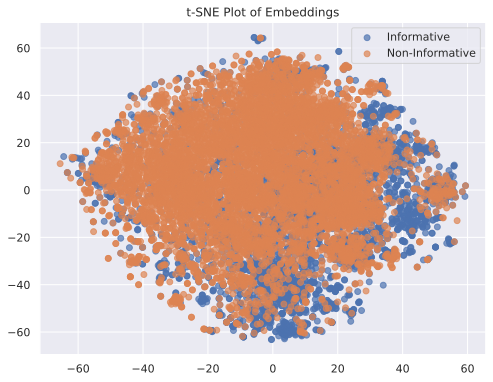

In [ ]:
# Create a scatter plot of the t-SNE embeddings
plt.figure(figsize=(8, 6))
for label in np.unique(train_informative_labels):
    indices = np.where(train_informative_labels == label)
    plt.scatter(
        embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=str(label), alpha=0.7
    )
plt.title("t-SNE Plot of Embeddings")
plt.legend()
plt.show()

### Information Types t-SNE plot

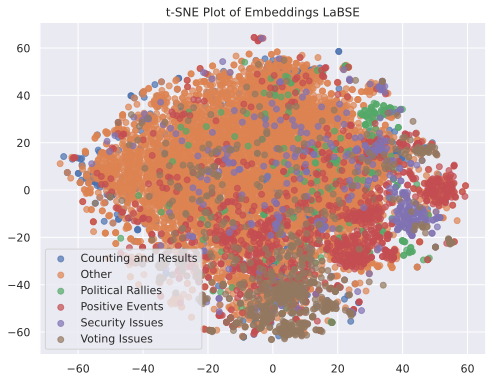

In [ ]:
# Create a scatter plot of the t-SNE embeddings
plt.figure(figsize=(8, 6))
for label in np.unique(train_merged_labels):
    indices = np.where(train_merged_labels == label)
    plt.scatter(
        embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=str(label), alpha=0.7
    )
plt.title("t-SNE Plot of Embeddings LaBSE")
plt.legend()
plt.show()

In [ ]:
# Util function to plot confusion matrix
def plot_cm(labels, predictions, class_labels, name):
    # predictions has values in [0,1]
    cm = confusion_matrix(labels, predictions)

    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(8, 6), dpi=100)

    # Scale up the size of all text
    # sns.set(font_scale=1.1)

    # Plot Confusion Matrix using Seaborn heatmap()
    # Parameters:
    # first param - confusion matrix in array format
    # annot = True: show the numbers in each heatmap cell
    # fmt = 'd': show numbers as integers.
    ax = sns.heatmap(cm, annot=True, fmt='d')

    # Set x-axis label and ticks
    ax.set_xlabel("Predicted Label", labelpad=20)
    ax.set_xticklabels(class_labels, fontsize=8, wrap=True)

    # Set y-axis label and ticks
    ax.set_ylabel("Gold Label", labelpad=20)
    ax.set_yticklabels(class_labels, fontsize=8, rotation=0, wrap=True)

    # Save the figure as an SVG file with timestamp in the file name
    plt.savefig(name, format='svg')

    plt.show()

In [ ]:
#Util function to plot confusion matrix
def plot_cm_with_percentages(labels, predictions, class_labels, name):
    # Compute confusion matrix
    cm = confusion_matrix(labels, predictions)

    # Calculate row-wise sums to get the total counts for each true label
    row_sums = cm.sum(axis=1, keepdims=True)

    # Calculate the percentages by dividing each element of the confusion matrix by its corresponding row sum
    cm_percentages = np.round((cm / row_sums) * 100, decimals=2)

    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(8,6), dpi=100)

    # Scale up the size of all text
    sns.set(font_scale = 1.1)

    # Plot Confusion Matrix using Seaborn heatmap()
    # Parameters:
    # first param - confusion matrix in array format
    # annot = True: show the numbers in each heatmap cell
    # fmt = '.2f': show numbers as floats with 2 decimal places
    ax = sns.heatmap(cm_percentages, annot=True, fmt='.2f', cbar=False)

    # Format the annotations as percentages
    for _, value in enumerate(ax.collections[0].axes.texts):
        if value.get_text() != '0.00':
            value.set_text(f"{float(value.get_text()):.2f}%")

    # Set x-axis label and ticks
    ax.set_xlabel("Predicted Label", labelpad=20)
    ax.set_xticklabels(class_labels, fontsize=9, wrap=True)

    # Set y-axis label and ticks
    ax.set_ylabel("Gold Label", labelpad=20)
    ax.set_yticklabels(class_labels, fontsize=9, rotation=0, wrap=True)

    # Save the figure as an SVG file with timestamp in the file name
    plt.savefig(name, format='svg')

    plt.show()


In [ ]:
# Rerun experiments on the baseline models to get final metrics across multiple runs

## Experiment 1: Train models with just the sentence embeddings

In [ ]:
model_lsvc = LinearSVC(class_weight='balanced', C=0.1)
model_lsvc.fit(train_embeddings, train_targets)

LinearSVC(C=0.1, class_weight='balanced')

              precision    recall  f1-score   support

           0       0.66      0.73      0.69       483
           1       0.85      0.80      0.83       922

    accuracy                           0.78      1405
   macro avg       0.76      0.77      0.76      1405
weighted avg       0.78      0.78      0.78      1405



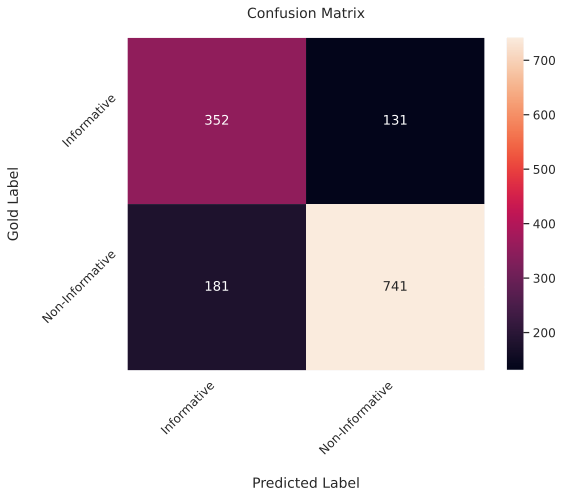

In [ ]:
#Calculating predictions, and accuracy score
pred_lsvc = model_lsvc.predict(val_embeddings)
#Building classification report
print(classification_report(val_targets,pred_lsvc))
plot_cm(val_targets, pred_lsvc, np.unique(train_informative_labels))

In [ ]:
# Effects on data sizes for the classification tasks
# What should i do- split the data into 100s, adding 100 for each time and retraining the model
# For each time record the precision recall and F1 score

In [ ]:
print(train_data.shape, test_data.shape)

(9926, 14) (2850, 14)


In [ ]:
informative_train_data = train_data[train_data['informative_label'] == 'Informative']
informative_test_data = test_data[test_data['informative_label'] == 'Informative']

In [ ]:
print(informative_train_data.shape, informative_test_data.shape)

(3414, 14) (980, 14)


In [ ]:
X_train = train_data['clean_text']
y_train = train_data['informative_label']
X_test = test_data['clean_text']
y_test = test_data['informative_label']

In [ ]:
test_data['informative_label'].unique()

array(['Non-Informative', 'Informative'], dtype=object)

In [ ]:
len(informative_train_data)/50

68.28

In [ ]:
import math

dataset_size = len(train_data)
increment_size = 200

# Calculate the total number of folds needed
num_folds = math.ceil(dataset_size / increment_size)

# Generate the list of fold sizes
fold_sizes = [min((i + 1) * increment_size, dataset_size) for i in range(num_folds)]

percentage_folds = [fold/dataset_size for fold in fold_sizes]
test_embeddings = embedder.encode(X_test.values)

In [ ]:
f1_scores = []
precisions = []
recalls = []

for fold_size in percentage_folds[:-1]:
  # Split the data into the current fold
  X_train_fold, _, y_train_fold, _= train_test_split(X_train, y_train, train_size=fold_size, stratify=y_train, random_state=42)

  # Label encode the targets
  label_encoder = LabelEncoder()
  label_encoder.fit(y_train_fold)
  y_train_fd = label_encoder.transform(y_train_fold)
  y_test_fd = label_encoder.transform(y_test)

  # pipe  = Pipeline([('vect',    CountVectorizer()),
  #       ('tfidf',   TfidfTransformer()),
  #     #  ('sampler', RandomOverSampler(sampling_strategy='not majority',random_state=42)),
  #       ('model',  LinearSVC(C=0.1, class_weight='balanced'))])

  # Fit the model on the training data
  # model = pipe.fit(X_train_fold, y_train_fd)
  print(f"Currently processing fold: {fold_size}")
  train_embeddings = embedder.encode(X_train_fold.values, device = device)
  model = LogisticRegression(max_iter=3000, class_weight='balanced')
  model.fit(train_embeddings, y_train_fd)
  predictions = model.predict(test_embeddings)

  # Calculate the classification report metrics
  report = classification_report(y_test_fd, predictions, output_dict=True)

  # Extract F1-score, precision, and recall
  f1_score = report['macro avg']['f1-score']
  precision = report['macro avg']['precision']
  recall = report['macro avg']['recall']

  # Append the metrics to the lists
  f1_scores.append(f1_score)
  precisions.append(precision)
  recalls.append(recall)

Currently processing fold: 0.02014910336490026
Currently processing fold: 0.04029820672980052
Currently processing fold: 0.060447310094700786
Currently processing fold: 0.08059641345960104
Currently processing fold: 0.10074551682450131
Currently processing fold: 0.12089462018940157
Currently processing fold: 0.14104372355430184
Currently processing fold: 0.1611928269192021
Currently processing fold: 0.18134193028410237
Currently processing fold: 0.20149103364900262
Currently processing fold: 0.2216401370139029
Currently processing fold: 0.24178924037880314
Currently processing fold: 0.2619383437437034
Currently processing fold: 0.2820874471086037
Currently processing fold: 0.30223655047350395
Currently processing fold: 0.3223856538384042
Currently processing fold: 0.34253475720330445
Currently processing fold: 0.36268386056820473
Currently processing fold: 0.38283296393310495
Currently processing fold: 0.40298206729800523
Currently processing fold: 0.4231311706629055
Currently processi

In [ ]:
iterations = range(1, len(precisions) + 1)

In [ ]:
iterations

range(1, 50)

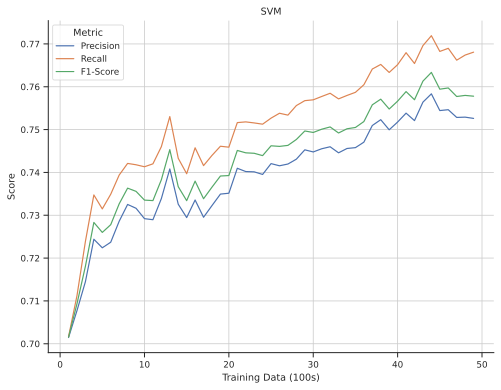

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have lists of precision, recall, and f1_scores
# containing the metrics for each iteration or fold

# Create a list of iteration or fold numbers
iterations = range(1, len(precisions) + 1)

# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Iteration': iterations,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
})

# Melt the DataFrame to transform the metrics into a single column
melted_df = pd.melt(metrics_df, id_vars=['Iteration'], var_name='Metric', value_name='Score')
sns.set(style='ticks', context='paper')
# Plot the graph using Seaborn's lineplot
plt.figure(figsize=(8, 6))
sns.lineplot(data=melted_df, x='Iteration', y='Score', hue='Metric')

# Set the y-axis limits to be between 0 and 1
# plt.ylim(0.4, 0.9)

# Remove top and right spines
sns.despine()

# Add gridlines
plt.grid(True)

# Set labels and title
plt.xlabel('Training Data (100s)')
plt.ylabel('Score')
plt.title('SVM')
# plt.savefig('svm_data_sizes.svg')

# Show the plot
plt.show()

In [ ]:
melted_df.to_csv('lr_binary_iterations.csv')

In [ ]:
tt_df = pd.read_csv('iterations_latest.csv')

In [ ]:
tt_df[]

Unnamed: 0  Iteration     Metric     Score
0             0          1  Precision  0.704686
1             1          2  Precision  0.721021
2             2          3  Precision  0.720527
3             3          4  Precision  0.727235
4             4          5  Precision  0.732167
..          ...        ...        ...       ...
292         292         95   F1-Score  0.745201
293         293         96   F1-Score  0.744381
294         294         97   F1-Score  0.747028
295         295         98   F1-Score  0.746357
296         296         99   F1-Score  0.744052

[297 rows x 4 columns]

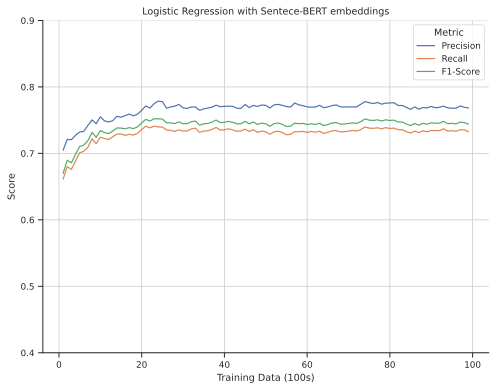

In [ ]:
sns.set(style='ticks', context='paper')
# Plot the graph using Seaborn's lineplot
plt.figure(figsize=(8, 6))
sns.lineplot(data=tt_df, x='Iteration', y='Score', hue='Metric')

# Set the y-axis limits to be between 0 and 1
plt.ylim(0.4, 0.9)

# Remove top and right spines
sns.despine()

# Add gridlines
plt.grid(True)

# Set labels and title
plt.xlabel('Training Data (100s)')
plt.ylabel('Score')
plt.title('Logistic Regression with Sentece-BERT embeddings')
plt.savefig('lr_data_sizes.svg')

# Show the plot
plt.show()

In [ ]:
melted_df1 = pd.read_csv('svm_binary_iterations.csv')
melted_df2 = pd.read_csv('lr_binary_iterations.csv')
# melted_df3 = pd.read_csv('bert_iterations.csv')

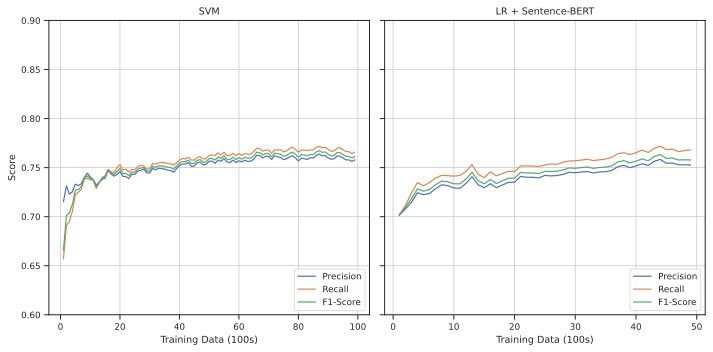

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have three melted_df DataFrames representing different models
melted_dfs = [melted_df1, melted_df2]
model_names = ['SVM', 'LR + Sentence-BERT']

# Set the Seaborn theme for the plot
sns.set(style='ticks', context='paper')

# Create subplots with shared y-axis
fig, axes = plt.subplots(nrows=1, ncols=len(melted_dfs), figsize=(10, 5), sharey=True)

# Loop through the melted_dfs and plot each one on a separate subplot
for i, (melted_df, model_name) in enumerate(zip(melted_dfs, model_names)):
    ax = axes[i]
    if model_name == 'XLM-R':
      sns.lineplot(data=melted_df, x='Iteration', y='Score', hue='Metric', ax=ax, marker='o')
    else:
      sns.lineplot(data=melted_df, x='Iteration', y='Score', hue='Metric', ax=ax)
    ax.set_title(model_name)

    # Set labels and title
    ax.set_xlabel('Training Data (100s)')
    if model_name == 'XLM-R':
      ax.set_xlabel('Training Data')
    ax.set_ylabel('Score')
    # ax.set_title('Progression of Precision, Recall, and F1-Score')

    # Set the y-axis limits to be between 0 and 1
    ax.set_ylim(0.6, 0.9)

    # Remove top and right spines
    # sns.despine()

    # Add gridlines
    ax.grid(True)

    # Place the legend at the bottom right
    ax.legend(loc='lower right')

# Adjust the spacing between subplots
plt.tight_layout()
# plt.savefig('combined_data_sizes.svg')

# Show the plot
plt.show()




In [ ]:
# Function that takes in the data and performs a random split
def split_model_data(model_data, classification_task = 'Binary'):

  stratify_label = 'informative_label'

  if classification_task == 'Multi-Class':
    stratify_label = 'merged_label'
    model_data = model_data[model_data['informative_label'] == 'Informative']

  # Perform train-test split (70% train, 30% test)
  train_data, test_data = train_test_split(
      model_data,  # Assuming 'text' column contains the input data
      test_size=0.2,
      shuffle=True,
      stratify=model_data[stratify_label]  # Perform stratified sampling based on labels
  )

  # # Perform further split on the test set to create validation set (10% validation, 20% test)
  # test_data, val_data = train_test_split(
  #     test_data,
  #     test_size=0.33,  # 10% of the test set (0.33 * 0.3 = 0.099 ≈ 10%)
  #     stratify=test_data[stratify_label]  # Perform stratified sampling based on labels
  # )

  # Print the sizes of each split
  print("Train set size:", len(train_data))
  # print("Validation set size:", len(val_data))
  print("Test set size:", len(test_data))

  return train_data, test_data

In [ ]:
def encode_labels(train_data, test_data, classification_task = 'Binary'):
  target_column = 'informative_label'

  if classification_task == 'Multi-Class':
    target_column = 'merged_label'

  label_encoder = LabelEncoder()
  label_encoder.fit(train_data[target_column])
  train_data["target"] = label_encoder.transform(train_data[target_column])
  # val_data["target"] = label_encoder.transform(val_data[target_column])
  test_data["target"] = label_encoder.transform(test_data[target_column])

  mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
  return train_data, test_data, mapping

In [ ]:
def train_test_tfidf_splits(no_of_splits, classification_task, model_data):
  results = {}
  mapping = {}
  for idx in range(0, no_of_splits):
    print(f"Currently running split {idx + 1}")

    # Get the train, test and validation data splits
    train_data, test_data = split_model_data(model_data, classification_task)

    # Encode the target variables
    train_data, test_data, mapping = encode_labels(train_data, test_data, classification_task)
    mapping = mapping

    # Get train sentences and targets
    train_sentences, train_targets = train_data.clean_text.values, train_data.target.values
    # val_sentences, val_targets = val_data.normalized_text.values, val_data.target.values
    test_sentences, test_targets = test_data.clean_text.values, test_data.target.values

    pipe  = Pipeline([('vect',    CountVectorizer()),
         ('tfidf',   TfidfTransformer()),
        #  ('sampler', RandomOverSampler(sampling_strategy='not majority',random_state=42)),
         ('model',  LinearSVC(C=0.1, multi_class='ovr'))])


    model = pipe.fit(train_sentences,
                     train_targets)
    predictions = model.predict(test_sentences)
    y_proba = model.decision_function(test_sentences)
    results[f"Run {idx+1}"] = (predictions, test_targets, y_proba)
  return results, mapping

In [ ]:
results, mapping = train_test_tfidf_splits(3, 'Binary', model_data)

Currently running split 1
Train set size: 11344
Test set size: 2837
Currently running split 2
Train set size: 11344
Test set size: 2837
Currently running split 3
Train set size: 11344
Test set size: 2837


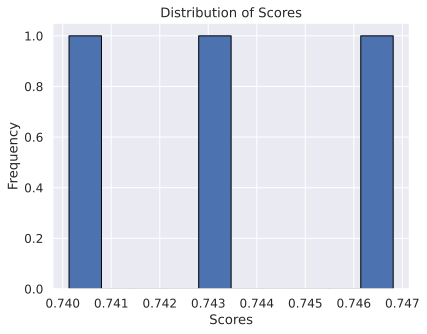

Macro Avg F1 Score across 3 runs:0.7434187934742965
Average Accuracy:0.7883914933615322
Average AUC (Score):0.8374791338166507


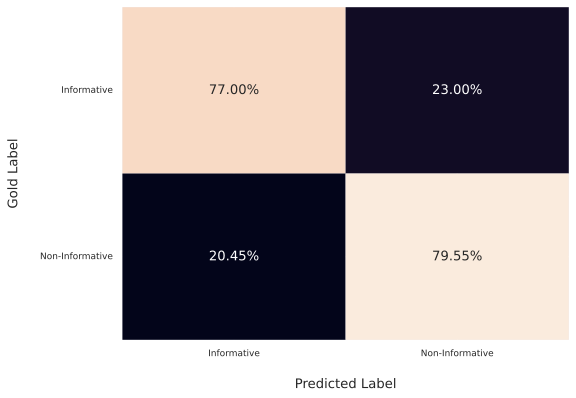

                 precision    recall  f1-score   support

    Informative       0.55      0.77      0.64       700
Non-Informative       0.91      0.80      0.85      2137

       accuracy                           0.79      2837
      macro avg       0.73      0.78      0.75      2837
   weighted avg       0.82      0.79      0.80      2837



In [ ]:
(best_model_predictions, best_model_true_labels), macro_f1_score, avg_report, all_scores, avg_accuracy, avg_auc = average_classification_report(results, mapping.keys(), classification_task = 'Binary')

# Plot the distribution
plt.hist(all_scores, bins=10, edgecolor='black')

# Set plot labels and title
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')

# Display the plot
plt.show()

print(f"Macro Avg F1 Score across 3 runs:{macro_f1_score}")

print(f"Average Accuracy:{avg_accuracy}")

print(f"Average AUC (Score):{avg_auc}")

plot_cm_with_percentages(best_model_predictions, best_model_true_labels, mapping.keys(), name="informative_types_new.svg")

print(classification_report(best_model_predictions, best_model_true_labels, target_names=mapping.keys()))

In [ ]:
pd.DataFrame(avg_report)

Informative  Non-Informative  accuracy    macro avg  weighted avg
precision     0.537568         0.919936       1.0     0.728752      0.829140
recall        0.779496         0.791407       1.0     0.785451      0.788579
f1-score      0.636029         0.850808       1.0     0.743419      0.799807
support     673.666667      2163.333333       1.0  2837.000000   2837.000000

In [ ]:
def train_test_multiple_splits(no_of_splits, classification_task, model_data, embedder, fuse_features):
  results = {}
  mapping = {}
  # Create a list of variables to be returned in this fn
  rt_train_data = None
  rt_test_data = None
  rt_model_lr = None
  rt_features_test = None
  for idx in range(0, no_of_splits):
    print(f"Currently running split {idx + 1}")

    # Get the train, test and validation data splits
    train_data, test_data = split_model_data(model_data, classification_task)

    # Encode the target variables
    train_data, test_data, mapping = encode_labels(train_data, test_data, classification_task)
    mapping = mapping

    rt_train_data = train_data
    rt_test_data = test_data

    # Get train sentences and targets
    train_sentences, train_targets = train_data.normalized_text.values, train_data.target.values
    # val_sentences, val_targets = val_data.normalized_text.values, val_data.target.values
    test_sentences, test_targets = test_data.normalized_text.values, test_data.target.values

    train_embeddings = embedder.encode(train_sentences)
    test_embeddings = embedder.encode(test_sentences)

    features_train = train_embeddings
    features_test = test_embeddings

    if fuse_features == True:
      # Include temporal information
      temporal_features = ['election_distance_abs','hour_cos','hour_sin']
      train_temporal_features = train_data[temporal_features]
      test_temporal_features = test_data[temporal_features]

      # Include sentiment features
      sentiment_features = ['negative', 'neutral', 'positive']
      train_sentiment_features = train_data[sentiment_features]
      test_sentiment_features = test_data[sentiment_features]

      # Include context
      train_context_embeddings = np.array(get_context_embeddings(train_data, train_data, embedder))
      test_context_embeddings = np.array(get_context_embeddings(test_data, model_data, embedder))

      # Merge the features together
      features_train = np.concatenate([train_embeddings, train_temporal_features, train_sentiment_features, train_context_embeddings], axis=1)
      features_test = np.concatenate([test_embeddings, test_temporal_features, test_sentiment_features, test_context_embeddings], axis=1)

    model_lr = LogisticRegression(max_iter=3000) # Set the max_iter to 1000 to fix convergence warning issue
    model_lr.fit(features_train, train_targets)
    rt_model_lr = model_lr
    predictions = model_lr.predict(features_test)
    y_proba = model_lr.predict_proba(features_test)
    rt_features_test = features_test

    results[f"Run {idx+1}"] = (predictions, test_targets, y_proba)
  return results, mapping, rt_train_data, rt_test_data, rt_features_test, model_lr

In [ ]:
results, mapping, train_data, test_data, rt_features_test, model_lr = train_test_multiple_splits(1, 'Multi-Class', model_data, embedder, fuse_features=True)

Currently running split 1
Train set size: 3901
Test set size: 976


In [ ]:
# Uncomment to get the misclassified election reports as a csv
# # Get the predictions flattened out
# predicted_targets = results['Run 1'][0]
# test_data['predicted_target'] = predicted_targets

# # Filter out all misclassified
# misclassified_data = test_data[test_data['predicted_target'] != test_data['target']]

# # Switch keys and values using a dictionary comprehension
# switched_dict = {value: key for key, value in mapping.items()}

# misclassified_data['predicted_label'] = misclassified_data['predicted_target'].map(switched_dict)

# misclassified_data[['text', 'label', 'merged_label', 'predicted_label']].to_csv('misclassified_posts.csv')

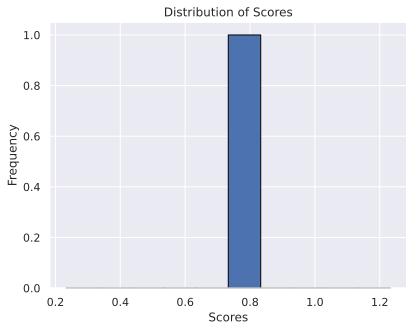

Macro Avg F1 Score across 3 runs:0.7329252378297163
Average Accuracy:0.7530737704918032
Average AUC (Score):0.0
                      precision    recall  f1-score   support

Counting and Results       0.77      0.75      0.76       209
   Political Rallies       0.59      0.73      0.65        63
     Positive Events       0.83      0.76      0.79       374
     Security Issues       0.70      0.77      0.74       112
       Voting Issues       0.71      0.74      0.73       218

            accuracy                           0.75       976
           macro avg       0.72      0.75      0.73       976
        weighted avg       0.76      0.75      0.75       976



In [ ]:
(best_model_predictions, best_model_true_labels), macro_f1_score, avg_report, all_scores, avg_accuracy, avg_auc = average_classification_report(results, mapping.keys(), classification_task='Multi-Class')

# Plot the distribution
plt.hist(all_scores, bins=10, edgecolor='black')

# Set plot labels and title
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')

# Display the plot
plt.show()

print(f"Macro Avg F1 Score across 3 runs:{macro_f1_score}")

print(f"Average Accuracy:{avg_accuracy}")

print(f"Average AUC (Score):{avg_auc}")

# plot_cm_with_percentages(best_model_predictions, best_model_true_labels, mapping.keys())

print(classification_report(best_model_predictions, best_model_true_labels, target_names=mapping.keys()))

In [ ]:
pd.DataFrame(avg_report)

Counting and Results  Political Rallies  Positive Events  \
precision              0.765854           0.589744         0.827988   
recall                 0.751196           0.730159         0.759358   
f1-score               0.758454           0.652482         0.792190   
support              209.000000          63.000000       374.000000   

           Security Issues  Voting Issues  accuracy   macro avg  weighted avg  
precision         0.704918       0.710526       1.0    0.719806      0.758945  
recall            0.767857       0.743119       1.0    0.750338      0.753074  
f1-score          0.735043       0.726457       1.0    0.732925      0.754708  
support         112.000000     218.000000       1.0  976.000000    976.000000

In [ ]:
# Detect each language in the test dataset and compare model performance across English and Swahili

In [ ]:
# Add the GCLDv3 magic
from IPython.display import JSON
from google.colab import output
from subprocess import getoutput
import os

def shell(command):
  if command.startswith('cd'):
    path = command.strip().split(maxsplit=1)[1]
    os.chdir(path)
    return JSON([''])
  return JSON([getoutput(command)])
output.register_callback('shell', shell)

In [ ]:
#@title Colab Shell
%%html
<div id=term_demo></div>
<script src="https://code.jquery.com/jquery-latest.js"></script>
<script src="https://cdn.jsdelivr.net/npm/jquery.terminal/js/jquery.terminal.min.js"></script>
<link href="https://cdn.jsdelivr.net/npm/jquery.terminal/css/jquery.terminal.min.css" rel="stylesheet"/>
<script>
  $('#term_demo').terminal(async function(command) {
      if (command !== '') {
          try {
              let res = await google.colab.kernel.invokeFunction('shell', [command])
              let out = res.data['application/json'][0]
              this.echo(new String(out))
          } catch(e) {
              this.error(new String(e));
          }
      } else {
          this.echo('');
      }
  }, {
      greetings: 'Welcome to Colab Shell',
      name: 'colab_demo',
      height: 250,
      prompt: 'colab > '
  });

In [ ]:
!pip install gcld3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.8/647.8 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gcld3: filename=gcld3-3.0.13-cp310-cp310-linux_x86_64.whl size=3645065 sha256=10a6b7eb42a1d614a8ee8f64d1ec76b4857d91f9f4a1b48a946aa8377f69ffa9
  Stored in directory: /root/.cache/pip/wheels/c2/11/e7/63c983a0b8506287ddd72b64db2a4d28f1e343eab85249a278
Successfully built gcld3


In [ ]:
import gcld3

detector = gcld3.NNetLanguageIdentifier(min_num_bytes=0,
                                        max_num_bytes=1000)

In [ ]:
def google_detect(text):
  return detector.FindLanguage(text).language

In [ ]:
test_data['lang'] = test_data.clean_text.map(google_detect)

In [ ]:
test_data.reset_index(drop=True, inplace=True)

In [ ]:
en_data = test_data[test_data['lang'] == 'en']
sw_data = test_data[test_data['lang'] == 'sw']

In [ ]:
print(en_data.shape, sw_data.shape)

(788, 19) (24, 19)


In [ ]:
# Assuming test_data is your DataFrame and 'google_lang' is the column you want to group by
grouped_data = test_data.groupby(['lang']).size().reset_index(name='count')

# Sort the DataFrame by the 'count' column in descending order
grouped_data_sorted = grouped_data.sort_values(by='count', ascending=False)

print(grouped_data_sorted[:10])

   lang  count
9    en    788
43   sw     24
47   zu     19
6    da     16
40   sn     15
0    af     11
45   xh      8
34   ny      5
35   pl      4
25   la      4


In [ ]:
en_indices = en_data.index.values
sw_indices = sw_data.index.values

In [ ]:
en_features_train = rt_features_test[en_indices]
sw_features_train = rt_features_test[sw_indices]

In [ ]:
en_predictions = model_lr.predict(en_features_train)
sw_predictions = model_lr.predict(sw_features_train)

In [ ]:
print(len(en_predictions))

788


In [ ]:
print(len(sw_predictions))

24


In [ ]:
en_labels = en_data.target.values
sw_labels = sw_data.target.values

In [ ]:
# Some reports don't have some labels

In [ ]:
mapping.keys()

dict_keys(['Counting and Results', 'Political Rallies', 'Positive Events', 'Security Issues', 'Voting Issues'])

In [ ]:
print(classification_report(en_labels, en_predictions))

              precision    recall  f1-score   support

           0       0.72      0.75      0.74       148
           1       0.72      0.60      0.66        63
           2       0.78      0.82      0.80       289
           3       0.79      0.71      0.74        99
           4       0.74      0.74      0.74       189

    accuracy                           0.76       788
   macro avg       0.75      0.72      0.73       788
weighted avg       0.75      0.76      0.75       788



In [ ]:
print(classification_report(sw_labels, sw_predictions))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.00      0.00      0.00         0
           2       0.77      0.91      0.83        11
           3       0.80      0.57      0.67         7
           4       0.00      0.00      0.00         2

    accuracy                           0.71        24
   macro avg       0.43      0.45      0.43        24
weighted avg       0.69      0.71      0.69        24



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

<ipython-input-62-135e403b6f94>:17: RuntimeWarning: invalid value encountered in true_divide
  cm_percentages2 = np.round((cm2 / row_sums2) * 100, decimals=2)


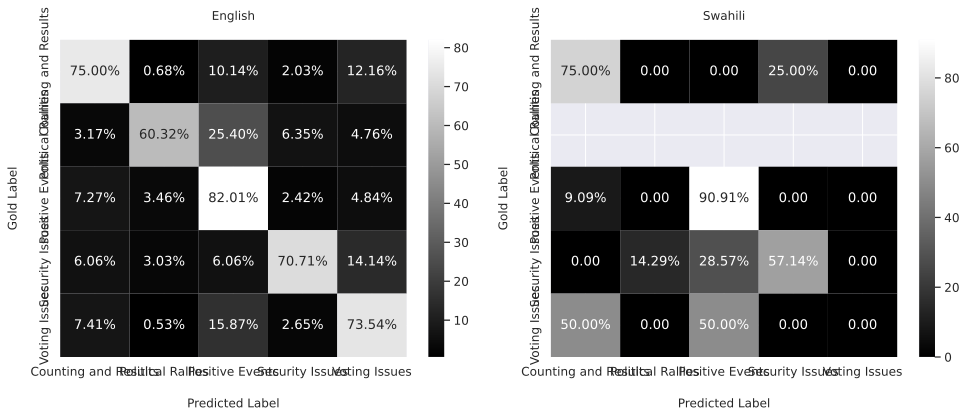

In [ ]:
plot_cm_with_percentages_mult(labels1=en_labels, predictions1=en_predictions,labels2=sw_labels, predictions2=sw_predictions,class_labels=mapping.keys())

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_cm_with_percentages_mult(labels1, predictions1, labels2, predictions2, class_labels, name=""):
    # Compute confusion matrices for both sets of predictions
    cm1 = confusion_matrix(labels1, predictions1)
    cm2 = confusion_matrix(labels2, predictions2)

    # Calculate row-wise sums to get the total counts for each true label for both sets
    row_sums1 = cm1.sum(axis=1, keepdims=True)
    row_sums2 = cm2.sum(axis=1, keepdims=True)

    # Calculate the percentages by dividing each element of the confusion matrix by its corresponding row sum
    cm_percentages1 = np.round((cm1 / row_sums1) * 100, decimals=2)
    cm_percentages2 = np.round((cm2 / row_sums2) * 100, decimals=2)

    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(14, 6), dpi=100)

    # Scale up the size of all text
    sns.set(font_scale=1.1)

    # Plot Confusion Matrix using Seaborn heatmap() for the first set of predictions
    ax1 = plt.subplot(1, 2, 1)
    sns.heatmap(cm_percentages1, annot=True, fmt='.2f', cmap='gist_gray', ax=ax1)
    for _, value in enumerate(ax1.collections[0].axes.texts):
        if value.get_text() != '0.00':
            value.set_text(f"{float(value.get_text()):.2f}%")
    ax1.set_xlabel("Predicted Label", fontsize=12, labelpad=20)
    ax1.set_xticklabels(class_labels)
    ax1.set_ylabel("Gold Label", fontsize=12, labelpad=20)
    ax1.set_yticklabels(class_labels)
    ax1.set_title("English", fontsize=12, pad=20)

    # Plot Confusion Matrix using Seaborn heatmap() for the second set of predictions
    ax2 = plt.subplot(1, 2, 2)
    sns.heatmap(cm_percentages2, annot=True, fmt='.2f', cmap='gist_gray', ax=ax2)
    for _, value in enumerate(ax2.collections[0].axes.texts):
        if value.get_text() != '0.00':
            value.set_text(f"{float(value.get_text()):.2f}%")
    ax2.set_xlabel("Predicted Label", fontsize=12, labelpad=20)
    ax2.set_xticklabels(class_labels)
    ax2.set_ylabel("Gold Label", fontsize=12, labelpad=20)
    ax2.set_yticklabels(class_labels)
    ax2.set_title("Swahili", fontsize=12, pad=20)

    plt.tight_layout()
    # plt.savefig('language_fairness.svg')
    plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score

def average_classification_report(predictions_dict, target_names, classification_task = 'Binary'):
    num_runs = len(predictions_dict)
    labels = list(target_names)  # Get unique labels

    # Initialize variables to accumulate metrics
    avg_precision = {label: 0.0 for label in labels}
    avg_recall = {label: 0.0 for label in labels}
    avg_f1_score = {label: 0.0 for label in labels}
    avg_support = {label: 0 for label in labels}
    avg_accuracy = 0.0
    avg_auc = 0.0

    # Initialize variables for macro average metrics
    macro_precision = 0.0
    macro_recall = 0.0
    macro_f1_score = 0.0

    # Variables to track best model
    best_model_f1_score = float('-inf')
    best_model_predictions = None
    best_model_true_labels = None

    all_scores = []
    accuracies = []
    auc_scores = []

    # Calculate metrics for each run and accumulate
    for model_id, (predictions, true_labels, y_proba) in predictions_dict.items():
        # Calculate accuracy
        accuracy = accuracy_score(predictions, true_labels)
        avg_accuracy += accuracy
        accuracies.append(accuracy)

        if classification_task == 'Binary':
          avg_auc += roc_auc_score(true_labels, y_proba)
          auc_scores.append(auc)

        report = classification_report(predictions, true_labels, target_names=target_names, output_dict=True)
        all_scores.append(report['macro avg']['f1-score'])

        # Accumulate precision, recall, f1-score, and support
        for label in labels:
            avg_precision[label] += report[label]['precision']
            avg_recall[label] += report[label]['recall']
            avg_f1_score[label] += report[label]['f1-score']
            avg_support[label] += report[label]['support']

        # Accumulate macro average metrics
        macro_precision += report['macro avg']['precision']
        macro_recall += report['macro avg']['recall']
        macro_f1_score += report['macro avg']['f1-score']

        # Check if current model has a higher macro average F1 score
        if report['macro avg']['f1-score'] > best_model_f1_score:
            best_model_f1_score = report['macro avg']['f1-score']
            best_model_predictions = predictions
            best_model_true_labels = true_labels

    # Average metrics across runs
    avg_precision = {label: avg_precision[label] / num_runs for label in labels}
    avg_recall = {label: avg_recall[label] / num_runs for label in labels}
    avg_f1_score = {label: avg_f1_score[label] / num_runs for label in labels}
    avg_support = {label: avg_support[label] / num_runs for label in labels}
    avg_accuracy /= num_runs
    avg_auc /= num_runs

    # Average macro average metrics across runs
    macro_precision /= num_runs
    macro_recall /= num_runs
    macro_f1_score /= num_runs

    # Create average classification report
    avg_report = classification_report(labels, labels, labels=labels, output_dict=True)
    for label in labels:
        avg_report[label]['precision'] = avg_precision[label]
        avg_report[label]['recall'] = avg_recall[label]
        avg_report[label]['f1-score'] = avg_f1_score[label]
        avg_report[label]['support'] = avg_support[label]

    # Add macro average metrics to the classification report
    avg_report['macro avg'] = {
        'precision': macro_precision,
        'recall': macro_recall,
        'f1-score': macro_f1_score,
        'support': np.sum(list(avg_support.values()))
    }

    # Calculate weighted average metrics
    weighted_precision = np.average(list(avg_precision.values()), weights=list(avg_support.values()))
    weighted_recall = np.average(list(avg_recall.values()), weights=list(avg_support.values()))
    weighted_f1_score = np.average(list(avg_f1_score.values()), weights=list(avg_support.values()))

    # Add weighted average metrics to the classification report
    avg_report['weighted avg'] = {
        'precision': weighted_precision,
        'recall': weighted_recall,
        'f1-score': weighted_f1_score,
        'support': np.sum(list(avg_support.values()))
    }


    return (best_model_predictions, best_model_true_labels), macro_f1_score, avg_report, all_scores, avg_accuracy, avg_auc

In [ ]:
model_data['label'].unique()

array(['Opinions', 'Political Rallies', 'Positive Events',
       'Security Issues', 'Voting Issues', 'Counting and Results',
       'Polling Station Administration', 'Staffing Issues', 'Other'],
      dtype=object)

In [ ]:
(best_model_predictions, best_model_true_labels), macro_f1_score, avg_report, all_scores, avg_accuracy = average_classification_report(results, mapping.keys())

# Plot the distribution
plt.hist(all_scores, bins=10, edgecolor='black')

# Set plot labels and title
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')

# Display the plot
plt.show()

print(f"Macro Avg F1 Score across 3 runs:{macro_f1_score}")

print(f"Average Accuracy:{avg_accuracy}")

print(pd.DataFrame(avg_report))

plot_cm_with_percentages(best_model_predictions, best_model_true_labels, mapping.keys())

print(classification_report(best_model_predictions, best_model_true_labels, target_names=mapping.keys()))

ValueError: ignored

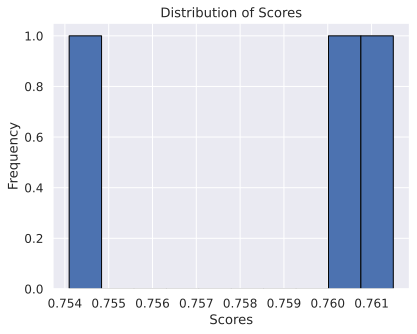

In [ ]:
# Plot the distribution
plt.hist(all_scores, bins=10, edgecolor='black')

# Set plot labels and title
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')

# Display the plot
plt.show()

In [ ]:
macro_f1_score

0.7587009916452372

In [ ]:
avg_accuracy

0.7796968628833275

In [ ]:
all_scores

[0.7614957792254093, 0.7605091930843374, 0.7540980026259649]

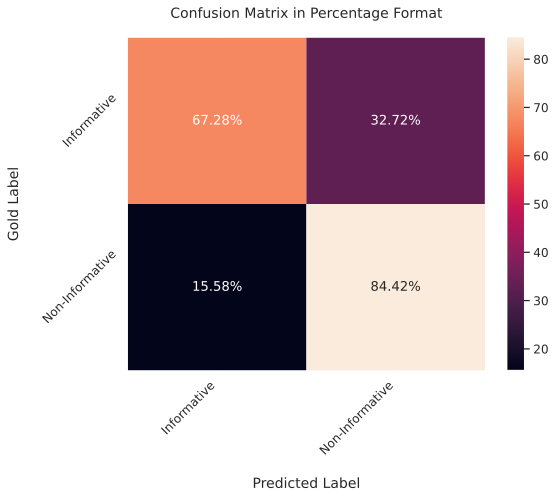

In [ ]:
plot_cm_with_percentages(best_model_predictions, best_model_true_labels, mapping.keys())

In [ ]:
print(classification_report(best_model_predictions, best_model_true_labels, target_names=mapping.keys()))

                 precision    recall  f1-score   support

    Informative       0.71      0.67      0.69      1033
Non-Informative       0.82      0.84      0.83      1804

       accuracy                           0.78      2837
      macro avg       0.77      0.76      0.76      2837
   weighted avg       0.78      0.78      0.78      2837



In [ ]:
pd.DataFrame(avg_report)

Informative  Non-Informative  accuracy    macro avg  weighted avg
precision     0.704577         0.819094       1.0     0.761835      0.777746
recall        0.671313         0.840954       1.0     0.756134      0.779703
f1-score      0.687528         0.829874       1.0     0.758701      0.778478
support    1024.333333      1812.666667       1.0  2837.000000   2837.000000

In [ ]:
model_lr = LogisticRegression(class_weight='balanced', max_iter=1000) # Set the max_iter to 1000 to fix convergence warning issue
model_lr.fit(train_embeddings, train_targets)

NameError: ignored

Classification Report for Logistic Regression with Sentence Embeddings
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       483
           1       0.85      0.80      0.83       922

    accuracy                           0.78      1405
   macro avg       0.76      0.77      0.76      1405
weighted avg       0.79      0.78      0.78      1405



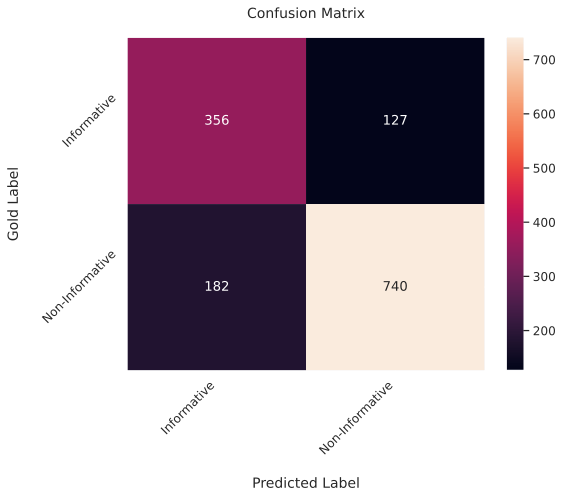

In [ ]:
#Calculating predictions, and accuracy score
pred_lr = model_lr.predict(val_embeddings)
accuracy_score(val_targets, pred_lr)
#Building classification report
print("Classification Report for Logistic Regression with Sentence Embeddings")
print(classification_report(val_targets,pred_lr))
plot_cm(val_targets, pred_lr, np.unique(train_informative_labels))

In [ ]:
# Conclusively compare LinearSVC and Logistic Regression

# SVC
scores = cross_val_score(model_lsvc, train_embeddings, train_targets, cv=5, scoring='f1_macro')
# Calculate the average F1 score
average_f1_score = scores.mean()
# Print the results
print("Cross Validation Scores for LinearSVC with just sentence embeddings")
print("Average F1 Score:", average_f1_score)
print("Individual F1 Scores:", scores)

In [ ]:
# Conclusively compare LinearSVC and Logistic Regression

# Logistic Regression
scores = cross_val_score(model_lr, train_embeddings, train_targets, cv=5, scoring='f1_macro')
# Calculate the average F1 score
average_f1_score = scores.mean()
# Print the results
print("Cross Validation Scores for Logistic Regression with just sentence embeddings")
print("Average F1 Score:", average_f1_score)
print("Individual F1 Scores:", scores)

Cross Validation Scores for Logistic Regression with just sentence embeddings
Average F1 Score: 0.7551770126597354
Individual F1 Scores: [0.74106215 0.75624898 0.75619547 0.7611448  0.76123367]


From the initial experiment of training two traditional ML models on the sentence embeddings; logistic regression and linear svc have very similar performance, logistic regression model is chosen to be used for further analysis as it is faster for training

## A peek into distance of election reports from election day

<Figure size 1200x1000 with 0 Axes>

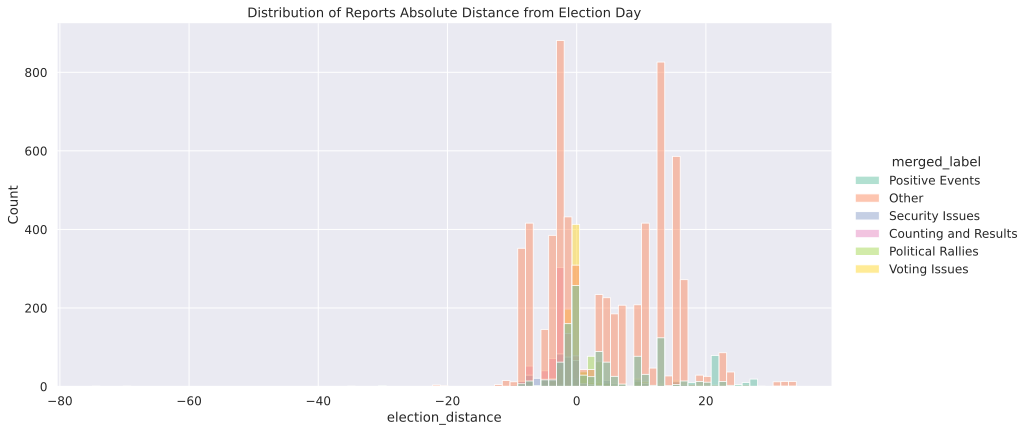

In [ ]:
# Visualise election distance distribution
# Set the figure size
plt.figure(figsize=(12, 10))
sns.set_palette("Set2")
sns.displot(train_data, x="election_distance", hue='merged_label', height=6, aspect=2)
plt.title('Distribution of Reports Absolute Distance from Election Day')
plt.show()

In [ ]:
train_data['election_distance_abs'].describe()

count    9926.000000
mean        6.810699
std         6.279159
min         0.000000
25%         2.000000
50%         5.000000
75%        11.000000
max        75.000000
Name: election_distance_abs, dtype: float64

In [ ]:
# Combine election distance and embeddings
len(train_embeddings)

9926

In [ ]:
election_distances = train_data.election_distance.values

In [ ]:
from sklearn.preprocessing import QuantileTransformer

# Create an instance of QuantileTransformer
transformer = QuantileTransformer(random_state=0)
# Reshape the input data to have the appropriate dimensions
train_election_distance_reshaped = train_data['election_distance'].values.reshape(-1, 1)
transformer.fit(train_election_distance_reshaped)

QuantileTransformer(random_state=0)

In [ ]:
train_data['election_distance_transformed'] = transformer.transform(train_election_distance_reshaped)
val_election_distance_reshaped = val_data['election_distance_abs'].values.reshape(-1, 1)
val_data['election_distance_transformed'] = transformer.transform(val_election_distance_reshaped)
test_election_distance_reshaped = test_data['election_distance_abs'].values.reshape(-1, 1)
test_data['election_distance_transformed'] = transformer.transform(test_election_distance_reshaped)

<Figure size 1200x1000 with 0 Axes>

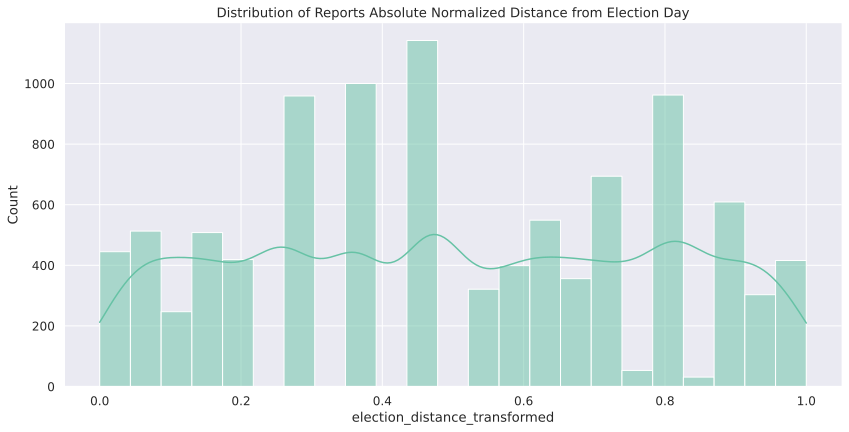

In [ ]:
# Visualise election distance after applying a quantile transformer
# Set the figure size
plt.figure(figsize=(12, 10))
sns.set_palette("Set2")
sns.displot(train_data, x="election_distance_transformed", height=6, aspect=2, kde=True)
plt.title('Distribution of Reports Absolute Normalized Distance from Election Day')
plt.show()

## Experiment 1.2: Train models with sentence embeddings and temporal information

In [ ]:
# Combine sentence embeddings with temporal information i.e. embedding of size 768 + 3 temporal features
features_train = np.concatenate([train_embeddings, train_data[['election_distance_abs','hour_sin', 'hour_cos']].values], axis=1)
features_test = np.concatenate([test_embeddings, test_data[['election_distance_abs','hour_sin', 'hour_cos']].values], axis=1)
features_val = np.concatenate([val_embeddings, val_data[['election_distance_abs','hour_sin', 'hour_cos']].values], axis=1)

In [ ]:
print(f"Train Shape:{features_train.shape}, Test Shape:{features_test.shape}, Validation Shape:{features_val.shape}")

Train Shape:(9926, 771), Test Shape:(2850, 771), Validation Shape:(1405, 771)


In [ ]:
model_lr = LogisticRegression(class_weight='balanced', max_iter=1000)
model_lr.fit(features_train, train_targets)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
# A util function used for evaluating model performance and pretty printing out the results
def evaluate_model(features_test, test_labels, model, labels, plot_percentage= True):
  pred = model.predict(features_test)
  print(f"Accuracy on hold-out set {accuracy_score(test_labels, pred)} \n")
  #Building classification report
  print(classification_report(test_labels,pred, target_names = labels))
  if plot_percentage:
    plot_cm_with_percentages(test_labels, pred, labels)
  else:
    plot_cm(test_labels, pred, labels)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy on hold-out set 0.7814946619217081 

                 precision    recall  f1-score   support

    Informative       0.66      0.74      0.70       483
Non-Informative       0.86      0.80      0.83       922

       accuracy                           0.78      1405
      macro avg       0.76      0.77      0.76      1405
   weighted avg       0.79      0.78      0.78      1405



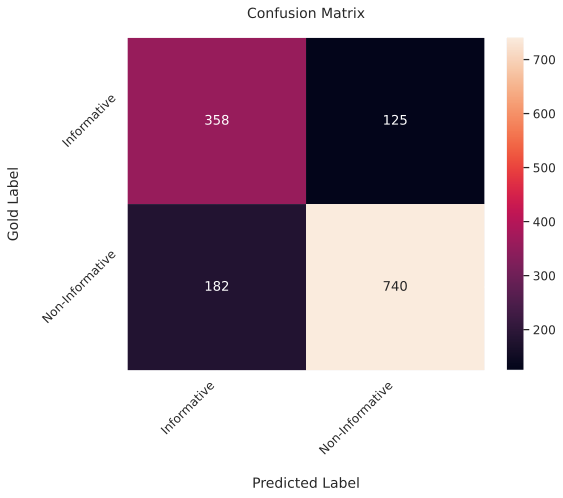

In [ ]:
evaluate_model(features_val, val_targets, model_lr, np.unique(train_informative_labels))

In [ ]:
  # Cross validation
scores = cross_val_score(model_lr, features_train, train_targets, cv=5, scoring='f1_macro')
# Calculate the average F1 score
average_f1_score = scores.mean()
# Print the results
print("Cross Validation Scores for Logistic Regression with sentence embeddings and temporal information included")
print("Average F1 Score:", average_f1_score)
print("Individual F1 Scores:", scores)

In [ ]:
model_lsvc = LinearSVC(class_weight='balanced', C=0.1, max_iter=1000)
model_lsvc.fit(features_train, train_targets)

In [ ]:
evaluate_model(features_val, val_targets, model_lsvc, np.unique(train_informative_labels))

In [ ]:
# Linear SVC
scores = cross_val_score(model_lsvc, features_train, train_targets, cv=5, scoring='f1_macro')
# Calculate the average F1 score
average_f1_score = scores.mean()
# Print the results
print("Average F1 Score:", average_f1_score)
print("Individual F1 Scores:", scores)

After including the temporal features with the sentence embeddings, we get slight improvements on the model's performance. The F1 score after cross validation improves from **0.7538799068734537** to **0.7581307298686257**. Though a slight improvement on the general model performance, including temporal infromation improves sensitivity/recall for the informative class as shown in the confusion matrices above.

## Creating Handcrafted features

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS

import spacy as sp
nlp = sp.load("en_core_web_sm")

import nltk
nltk.download('vader_lexicon')
sentiment_analyzer = VS()

nltk.download("stopwords")
from nltk.corpus import stopwords
enStop = stopwords.words('english')
enStop_dict={e: 0 for e in enStop}

from nltk.stem.porter import *
stemmer = PorterStemmer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load actionable verbs
def load_actionable_verbs(df, important_list={'Political Rallies':0,'Positive Events':0,'Security Issues':0,'Voting Issues':0,'Counting and Results':0}):
    actionnable_verb_list_dict={}
    for index,row in df.iterrows():
        tweet_text=row['text']
        category=row['merged_label']
        if category in important_list:
            if category not in actionnable_verb_list_dict:
                actionnable_verb_list_dict[category]=[]
            doc=nlp(tweet_text)
            verbs=[token.text for token in doc if token.pos_ == "VERB"]
            for v in verbs:
                if len(v)>=3 and v not in enStop_dict:
                    actionnable_verb_list_dict[category].append(v)
    return {e:sorted(nltk.FreqDist(actionnable_verb_list_dict[e]).items(), key=lambda kv: kv[1],reverse=True) for e in actionnable_verb_list_dict}

In [ ]:
%time sorted_actionnable_verb_dict = load_actionable_verbs(df=train_data)

CPU times: user 29.3 s, sys: 119 ms, total: 29.4 s
Wall time: 29.5 s


In [ ]:
sorted_actionnable_verb_dict2dict_top10={}
for event in sorted_actionnable_verb_dict:
    sorted_actionnable_verb_dict2dict_top10[event]={}
    for tup in sorted_actionnable_verb_dict[event][:10]:
        sorted_actionnable_verb_dict2dict_top10[event][stemmer.stem(tup[0])]=tup[1]
sorted_actionnable_verb_dict2dict_top10.keys()

dict_keys(['Positive Events', 'Security Issues', 'Counting and Results', 'Political Rallies', 'Voting Issues'])

In [ ]:
print(f"Positive Events: {sorted_actionnable_verb_dict['Positive Events'][:10]}")
print(f"Political Rallies: {sorted_actionnable_verb_dict['Political Rallies'][:10]}")
print(f"Security Issues: {sorted_actionnable_verb_dict['Security Issues'][:10]}")
print(f"Voting Issues: {sorted_actionnable_verb_dict['Voting Issues'][:10]}")
print(f"Counting and Results: {sorted_actionnable_verb_dict['Counting and Results'][:10]}")

Positive Events: [('vote', 57), ('Let', 53), ('voting', 36), ('going', 31), ('ensure', 30), ('maintain', 24), ('let', 23), ('voted', 22), ('tallying', 20), ('cast', 19)]
Political Rallies: [('vote', 22), ('led', 18), ('promised', 17), ('said', 11), ('addressed', 11), ('elected', 11), ('urged', 10), ('held', 8), ('met', 8), ('claimed', 8)]
Security Issues: [('shot', 16), ('acting', 13), ('found', 12), ('said', 11), ('tallying', 10), ('trying', 9), ('arrested', 9), ('heard', 8), ('killed', 8), ('come', 8)]
Voting Issues: [('vote', 56), ('missing', 48), ('registered', 27), ('found', 23), ('voting', 22), ('register', 22), ('voted', 21), ('Bribing', 17), ('working', 15), ('told', 15)]
Counting and Results: [('tallying', 41), ('tallied', 26), ('cast', 22), ('registered', 20), ('leading', 20), ('announce', 19), ('uploaded', 18), ('declared', 16), ('rejected', 16), ('casted', 15)]


In [ ]:
stopList = ["http", "https", "rt", "@", ":", "t.co", "co", "amp", "&amp;", "...", "\n", "\r"]
stopList.extend(string.punctuation)

local_tokenizer = TweetTokenizer()
def tokenizer_wrapper(text):
    return local_tokenizer.tokenize(text)

def normalize(s):
        """
        Given a text, cleans and normalizes it. Feel free to add your own stuff.
        From: https://www.kaggle.com/mschumacher/using-fasttext-models-for-robust-embeddings
        """
        s = s.lower()
        # Replace numbers and symbols with language
        s = s.replace('&', ' and ')
        s = s.replace('@', ' at ')
        s = s.replace('0', 'zero')
        s = s.replace('1', 'one')
        s = s.replace('2', 'two')
        s = s.replace('3', 'three')
        s = s.replace('4', 'four')
        s = s.replace('5', 'five')
        s = s.replace('6', 'six')
        s = s.replace('7', 'seven')
        s = s.replace('8', 'eight')
        s = s.replace('9', 'nine')
        return s

def tokenize_tweet(string):
    string=string.lower()
    # Clean and Refine (remove URL, special characters)
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    string = re.sub(giant_url_regex, "", string)

    string = re.sub(r"\'s", "s", string)
    string = re.sub(r"\'ve", "ve", string)
    string = re.sub(r"\'t", "t", string)
    string = re.sub(r"\'re", "re", string)
    string = re.sub(r"\'d", "d", string)
    string = re.sub(r"\'ll", "ll", string)

    #Skip retweet signs, @ symbols, and special chars such as punctuations
    string = re.sub(r"[^A-Za-z]", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    tokens=[]
    for w in string.split():
        # Short words skip and Stop word removal
        if len(w) >= 3 and w not in enStop_dict:
            tokens.append(w)
    return tokens

In [ ]:
def return_features(tweet_text):
    #1. No. of hashtags (numeric)
    hashtag_count=tweet_text.count("#")
    #3. Sentiment polarity (categorical,, -1, 0 or 1)
    sentiment = sentiment_analyzer.polarity_scores(tweet_text)
    sentiment_cpd=sentiment['compound']
    sentiment_neg=sentiment['neg']
    sentiment_neu=sentiment['neu']
    sentiment_pos=sentiment['pos']

    #2. No. of special verbs such as, trapped, stuck, move etc (dataset statistical analysis)
    #['MovePeople', 'EmergingThreats', 'GoodsServices', 'SearchAndRescue', 'ServiceAvailable']
    tokens=tokenize_tweet(tweet_text)
    is_action1=int(any(stemmer.stem(i) in sorted_actionnable_verb_dict2dict_top10['Political Rallies'] for i in tokens))
    is_action2=int(any(stemmer.stem(i) in sorted_actionnable_verb_dict2dict_top10['Security Issues'] for i in tokens))
    is_action3=int(any(stemmer.stem(i) in sorted_actionnable_verb_dict2dict_top10['Voting Issues'] for i in tokens))
    is_action4=int(any(stemmer.stem(i) in sorted_actionnable_verb_dict2dict_top10['Counting and Results'] for i in tokens))
    is_action5=int(any(stemmer.stem(i) in sorted_actionnable_verb_dict2dict_top10['Positive Events'] for i in tokens))

    #4. Tweet length (word_length, char_length, numeric)
    tokens=tweet_text.split(" ")
    word_length=len(tokens)
    char_length=len(tweet_text)

    #5. URL count (numeric)
    url_count=len(re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',tweet_text))
    #6. Digit count (int, numeric)
    digital_count=len( re.findall('[0-9]+', tweet_text))

    #7. Retweet check (0 or 1)
    is_retweet=int(tweet_text[:2]=="RT")
    # 8. caps ratio (float, numeric)
    caps_ratio=len("".join(re.findall('[A-Z]+', tweet_text)))/char_length

    #9. Special chars count
    at_count=tweet_text.count("@")
    exclaim_count=tweet_text.count("!")
    question_count=tweet_text.count("?")

    #10. : in first token check (0 or 1)
    colon_check=int(":" in tokens[0])

    #11. Named Entity count (numeric)
    doc = nlp(tweet_text)
    ner_count=len(doc.ents)
#     print(doc.ents)

    return_list=[hashtag_count,sentiment_cpd,sentiment_neg,sentiment_neu,sentiment_pos,is_action1,
                    is_action2,is_action3,is_action4,is_action5,word_length,char_length,
                    url_count,digital_count,is_retweet,caps_ratio,at_count,exclaim_count,question_count,
                    colon_check,ner_count]
    return return_list

def normalize_by_columns(crafted_features_matrix,columns_to_normalize=["hashtag_count","word_length","char_length","url_count","digital_count","at_count","exclaim_count","question_count","ner_count"]):
    crafted_features_matrix_=crafted_features_matrix.copy()
    to_normalize_features_matrix=crafted_features_matrix_[columns_to_normalize]
    from sklearn import preprocessing
    x = to_normalize_features_matrix.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    normalized_features_matrix = pd.DataFrame(x_scaled,columns=columns_to_normalize)
    normalized_features_matrix.head()
    for column in columns_to_normalize:
        crafted_features_matrix_[column]=normalized_features_matrix[column]
    return crafted_features_matrix_

In [ ]:
def getReportsByLabel(label= 'Informative', df = train_data):
        return df[df.informative_label == label].sample(1)['text'].item()

In [ ]:
test_report=getReportsByLabel()
print("Test for :",test_report)
feature_names=["hashtag_count",'sentiment_cpd','sentiment_neg','sentiment_neu','sentiment_pos',"is_action1","is_action2","is_action3","is_action4",
               "is_action5","word_length","char_length","url_count","digital_count",
              "is_retweet","caps_ratio","at_count","exclaim_count","question_count",
              "colon_check","ner_count"]
import datetime
start_time=datetime.datetime.now()
features=return_features(test_report)

for idx,fature_name in enumerate(feature_names):
    print(fature_name,"====>",features[idx])

Test for : Police struggling to clear roadblocks on Nyerere Road at the heart of Kisumu town. Protesters lit fires.. gunfire can be heard from afar.
hashtag_count ====> 0
sentiment_cpd ====> -0.2732
sentiment_neg ====> 0.172
sentiment_neu ====> 0.733
sentiment_pos ====> 0.095
is_action1 ====> 0
is_action2 ====> 1
is_action3 ====> 0
is_action4 ====> 0
is_action5 ====> 0
word_length ====> 23
char_length ====> 137
url_count ====> 0
digital_count ====> 0
is_retweet ====> 0
caps_ratio ====> 0.0364963503649635
at_count ====> 0
exclaim_count ====> 0
question_count ====> 0
colon_check ====> 0
ner_count ====> 1


In [ ]:
feature_names=["hashtag_count",'sentiment_cpd','sentiment_neg','sentiment_neu','sentiment_pos',"is_action1","is_action2","is_action3","is_action4","is_action5",
               "word_length","char_length","url_count","digital_count",
              "is_retweet","caps_ratio","at_count","exclaim_count","question_count",
              "colon_check","ner_count","label","informative_label"]

In [ ]:
def create_feature_matrix(df):
  crafted_features_matrix=pd.DataFrame(columns=feature_names)
  texts=df['text'].to_numpy()
  labels=df['label'].to_numpy()
  merged_labels=df['merged_label'].to_numpy()
  informative_labels =  df['informative_label'].to_numpy()
  for index,text in enumerate(texts):
      if index%1000==0:
          print("Now is processing at index",index)
      features=return_features(text)
      features.append(merged_labels[index])
      features.append(informative_labels[index])
      crafted_features_matrix.loc[len(crafted_features_matrix)]=features
  return crafted_features_matrix

In [ ]:
train_features_matrix = create_feature_matrix(train_data)

Now is processing at index 0
Now is processing at index 1000
Now is processing at index 2000
Now is processing at index 3000
Now is processing at index 4000
Now is processing at index 5000
Now is processing at index 6000
Now is processing at index 7000
Now is processing at index 8000
Now is processing at index 9000


In [ ]:
train_features_matrix.shape

(9926, 23)

In [ ]:
test_features_matrix = create_feature_matrix(test_data)

Now is processing at index 0
Now is processing at index 1000
Now is processing at index 2000


In [ ]:
test_features_matrix.shape

(2850, 23)

In [ ]:
val_features_matrix = create_feature_matrix(val_data)

Now is processing at index 0
Now is processing at index 1000


In [ ]:
# List to hold additional features needed in the code in the latter sections
additional_features = ['election_distance_abs', 'election_distance_transformed','hour_sin','hour_cos','Election Date', 'date', 'normalized_text']

In [ ]:
train_additional_df = train_data[additional_features]
train_additional_df.shape

(9926, 7)

In [ ]:
test_additional_df = test_data[additional_features]
test_additional_df.shape

(2850, 7)

In [ ]:
val_additional_df = val_data[additional_features]
val_additional_df.shape

(1405, 7)

In [ ]:
train_features_matrix = normalize_by_columns(train_features_matrix)
val_features_matrix = normalize_by_columns(val_features_matrix)
test_features_matrix = normalize_by_columns(test_features_matrix)

In [ ]:
# Reset the index of 'crafted_features_matrix'
train_features_matrix.reset_index(drop=True, inplace=True)
# Reset the index of 'temporal_df'
train_additional_df.reset_index(drop=True, inplace=True)
train_merged_df = pd.concat([train_features_matrix, train_additional_df], axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Reset the index of 'crafted_features_matrix'
test_features_matrix.reset_index(drop=True, inplace=True)
# Reset the index of 'temporal_df'
test_additional_df.reset_index(drop=True, inplace=True)
test_merged_df = pd.concat([test_features_matrix, test_additional_df], axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Reset the index of 'crafted_features_matrix'
val_features_matrix.reset_index(drop=True, inplace=True)
# Reset the index of 'temporal_df'
val_additional_df.reset_index(drop=True, inplace=True)
val_merged_df = pd.concat([val_features_matrix, val_additional_df], axis=1)

In [ ]:
model_features = ["hashtag_count",'sentiment_cpd','sentiment_neg','sentiment_neu','sentiment_pos',
                  "is_action1","is_action2","is_action3","is_action4","is_action5",
                  "word_length","char_length","url_count","digital_count",
                  "is_retweet","caps_ratio","at_count","exclaim_count","question_count",
                  "colon_check","ner_count","election_distance_abs", "hour_sin", "hour_cos"]

In [ ]:
train_matrix =np.concatenate([train_embeddings, train_merged_df[model_features].values], axis=1)
val_matrix = np.concatenate([val_embeddings, val_merged_df[model_features].values], axis=1)
test_matrix = np.concatenate([test_embeddings, test_merged_df[model_features].values], axis=1)

In [ ]:
informative_le = preprocessing.LabelEncoder()
informative_le.fit(train_merged_df['informative_label'])
train_informative_targets = informative_le.transform(train_merged_df['informative_label'])
val_informative_targets = informative_le.transform(val_merged_df['informative_label'])
test_informative_targets = informative_le.transform(test_merged_df['informative_label'])

In [ ]:
print(train_informative_targets.shape, val_informative_targets.shape, test_informative_targets.shape)

(9926,) (1405,) (2850,)


## Experiment 2: Train models with sentence embeddings, temporal information and handcrafted features

In [ ]:
model_lr = LogisticRegression(class_weight='balanced', max_iter= 5000)
model_lr.fit(train_matrix, train_informative_targets)

LogisticRegression(class_weight='balanced', max_iter=5000)

Accuracy on hold-out set 0.7758007117437722 

                 precision    recall  f1-score   support

    Informative       0.66      0.73      0.69       483
Non-Informative       0.85      0.80      0.82       922

       accuracy                           0.78      1405
      macro avg       0.75      0.77      0.76      1405
   weighted avg       0.78      0.78      0.78      1405



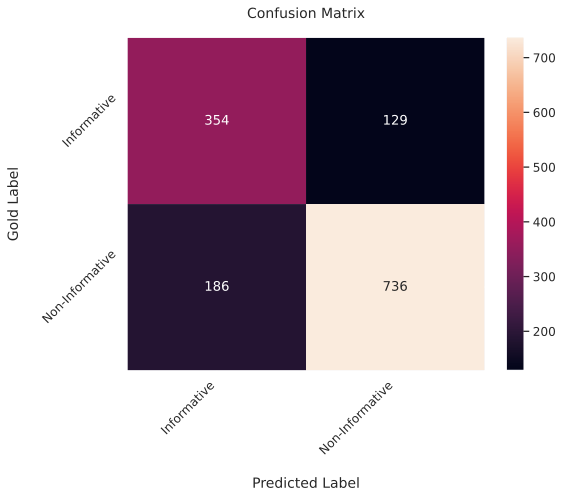

In [ ]:
evaluate_model(val_matrix, val_informative_targets, model_lr, np.unique(train_informative_labels))

In [ ]:
# model_lsvc = LinearSVC(class_weight='balanced', max_iter=5000, C=0.1)
# model_lsvc.fit(train_matrix, train_informative_targets)

In [ ]:
# evaluate_model(val_matrix, val_informative_targets, model_lsvc, np.unique(train_informative_labels))

In [ ]:
# Compare LR and SVC using cross-validation
scores = cross_val_score(model_lr, train_matrix, train_informative_targets, cv=5, scoring='f1_macro')
# Calculate the average F1 score
average_f1_score = scores.mean()
# Print the results
print("Average F1 Score:", average_f1_score)
print("Individual F1 Scores:", scores)

In [ ]:
# Compare SVC using cross-validation
scores = cross_val_score(model_lsvc, train_matrix, train_informative_targets, cv=5, scoring='f1_macro')
# Calculate the average F1 score
average_f1_score = scores.mean()
# Print the results
print("Average F1 Score:", average_f1_score)
print("Individual F1 Scores:", scores)

Summary: In this section i included the temporal features with all the other list of handcrafted features

## Create context embeddings

In [ ]:
def get_context_embeddings(df, support_df, embedder, context_size=3, embedding_dim=768):
  '''
  This function takes two dataframes, the first, df - is the dataframe to calculate
  context embeddings for while the support df is the reference to use to check the
  context, in the case of train data, both the df and support df will be the same,
  this is to ensure that no test data leaks into the training context embeddings. For
  test embeddings, the support df will be the whole dataset
  '''
  context_embeddings = []
  sorted_dates = df.sort_values('date')['date']
  dates_list = sorted_dates.to_list()
  # Iterate over rows using iterrows()
  for index, row in df.iterrows():
    current_date = row['date']
    current_date_index = dates_list.index(current_date)
    previous_posts = dates_list[max(0, current_date_index - context_size) : current_date_index]
    context_embed=np.zeros((context_size, embedding_dim))
    for idx, dt in enumerate(previous_posts):
      record = support_df[support_df['date'] == dt].iloc[0]
      # Only consider context fromt the same election
      if record['Election Date'] == row['Election Date']:
        context_embed[idx] = embedder.encode(record.normalized_text)
    embed = np.average(context_embed, axis=0)
    context_embeddings.append(embed)
  return context_embeddings

In [ ]:
def get_embeddings_context(df, embedder):
  cpy_df = df['context'].fillna('')
  contexts = cpy_df.values
  return [np.average(np.array(embedder.encode(ctx.split(' [SEP] '))), axis=0) for ctx in contexts]

In [ ]:
# Section to validate the context used

In [ ]:
train_context_embeddings = get_context_embeddings(train_data, train_data, embedder)

In [ ]:
train_context_embeddings = np.array(train_context_embeddings)

In [ ]:
test_context_embeddings = get_context_embeddings(test_data, model_data, embedder)

In [ ]:
test_context_embeddings = np.array(test_context_embeddings)

In [ ]:
train_val_combined = pd.concat([train_data, val_data])

In [ ]:
val_context_embeddings = get_context_embeddings(val_data, train_val_combined, embedder)

In [ ]:
val_context_embeddings = np.array(val_context_embeddings)

In [ ]:
features_train=np.concatenate([train_embeddings, train_context_embeddings, train_merged_df[model_features].values], axis=1)
features_train.shape

(9926, 1560)

In [ ]:
features_test=np.concatenate([test_embeddings, test_context_embeddings, test_merged_df[model_features].values], axis=1)
features_test.shape

(2850, 1560)

In [ ]:
features_val=np.concatenate([val_embeddings, val_context_embeddings, val_merged_df[model_features].values], axis=1)
features_val.shape

(1405, 1560)

In [ ]:
# Encode the labels to numeric format
informative_le = preprocessing.LabelEncoder()
informative_le.fit(train_data['informative_label'])
train_targets = informative_le.transform(train_data['informative_label'])
test_targets = informative_le.transform(test_data['informative_label'])
val_targets = informative_le.transform(val_data['informative_label'])

In [ ]:
# Perform cross validation
scores = cross_val_score(LogisticRegression(class_weight='balanced', max_iter=5000), features_train, train_targets, cv=5, scoring='f1_macro')

# Calculate average F1 score
average_score = scores.mean()

In [ ]:
average_score

0.7652962281693046

Accuracy on hold-out set 0.7758007117437722 

                 precision    recall  f1-score   support

    Informative       0.66      0.71      0.68       483
Non-Informative       0.84      0.81      0.83       922

       accuracy                           0.78      1405
      macro avg       0.75      0.76      0.76      1405
   weighted avg       0.78      0.78      0.78      1405



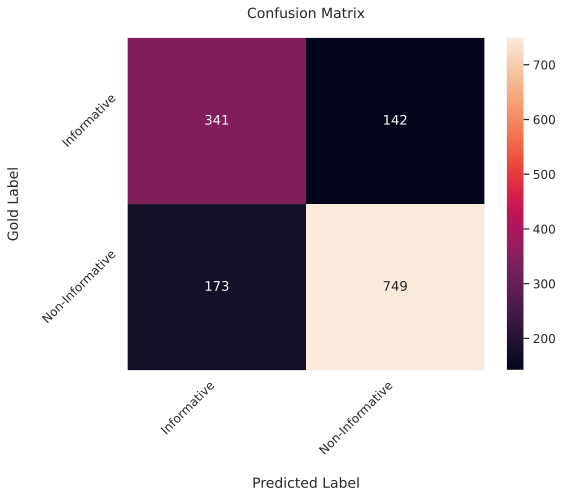

In [ ]:
model_lr = LogisticRegression(class_weight='balanced', max_iter=3000)
model_lr.fit(features_train, train_targets)
evaluate_model(features_val, val_targets, model_lr, np.unique(train_informative_labels))

In [ ]:
## Carry out ablation study to identify the contribution of each feature from original baseline

In [ ]:
grouped_features = {
    'temporal_features': ["election_distance_abs", "hour_sin","hour_cos"],
    'sentiment_features' : ['sentiment_cpd','sentiment_neg','sentiment_neu','sentiment_pos'],
    'action_features': ["is_action1","is_action2","is_action3","is_action4","is_action5"],
    'text_features': ['word_length','char_length',"caps_ratio","at_count","exclaim_count",
                      "question_count","colon_check","ner_count"],
    'tweet_features': ['hashtag_count',"url_count","digital_count","is_retweet"],
    'context_embeddings': True
}

In [ ]:
feature_performance = {}
# # Create a Linear SVC classifier
# classifier = LogisticRegression(class_weight='balanced', max_iter=5000)

In [ ]:
import warnings
warnings.filterwarnings(action='once')

In [ ]:
from sklearn.metrics import f1_score


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_targets

In [ ]:
for grouped_feature in grouped_features.keys():
  if grouped_features[grouped_feature] == True:
      # Train without any context
      print("Training without any context embeddings...")
      features_train=np.concatenate([train_embeddings, train_merged_df[model_features].values], axis=1)
  else:
      print(f"Training without the following features {grouped_features[grouped_feature]}")
      features_to_include = list(set(model_features) - set(grouped_features[grouped_feature]))
      features_train=np.concatenate([train_embeddings, train_context_embeddings, train_merged_df[features_to_include].values], axis=1)

  # Perform cross validation
  classifier = LogisticRegression(class_weight='balanced', max_iter=5000)
  scores = cross_val_score(classifier, features_train, train_targets, cv=5, scoring='f1_macro')
  # Calculate average F1 score
  modified_performance = scores.mean()
  feature_performance[grouped_feature] = modified_performance
  print(f"Feature: {grouped_feature}")
  print(f"Modified Performance: {modified_performance}")
  print("")

In [ ]:
features_train = np.concatenate([train_embeddings, train_context_embeddings, train_merged_df[model_features].values], axis=1)
features_test = np.concatenate([test_embeddings, test_context_embeddings, test_merged_df[model_features].values], axis=1)
features_val = np.concatenate([val_embeddings, val_context_embeddings, val_merged_df[model_features].values], axis=1)

classifier = LogisticRegression(class_weight='balanced', max_iter=5000)
scores = cross_val_score(classifier, features_train, train_targets, cv=5, scoring='f1_macro')
# Calculate average F1 score
original_performance = scores.mean()
print(f"F1 score : {original_performance}")

In [ ]:
performance_changes = []
for grouped_feature in feature_performance.keys():
  modified_f1_macro = feature_performance[grouped_feature]
  performance_change = original_performance - modified_f1_macro
  performance_changes.append(performance_change)

In [ ]:
performance_changes

In [ ]:
# Set the positions of the bars on the x-axis
x_pos = np.arange(len(feature_performance.keys()))

# Plotting the F1 score changes using vertical bars
plt.bar(x_pos, performance_changes)

# Adding labels and title
plt.xlabel('Features')
plt.ylabel('Change in F1 Score')
plt.title('Ablation Study: Change in F1 Score for Each Feature')

# Rotating x-axis labels for better readability
plt.xticks(x_pos, feature_performance.keys(), rotation=90)

# Displaying the plot
plt.show()

In [ ]:
# LR
scores = cross_val_score(model_lr, train_embeddings, train_targets, cv=5, scoring='f1_macro')
# Calculate the average F1 score
average_f1_score = scores.mean()
# Print the results
print("Average F1 Score:", average_f1_score)
print("Individual F1 Scores:", scores)

In [ ]:
best_features = ['temporal_features', 'action_features', 'sentiment_features']
best_features_to_include = []
for f in best_features:
  best_features_to_include = best_features_to_include + grouped_features[f]

In [ ]:
best_features_to_include

['election_distance_abs',
 'hour_sin',
 'hour_cos',
 'is_action1',
 'is_action2',
 'is_action3',
 'is_action4',
 'is_action5',
 'sentiment_cpd',
 'sentiment_neg',
 'sentiment_neu',
 'sentiment_pos']

In [ ]:
# Compare all the best models on the test dataset

# Comparison between the baseline model with sentence embeddings, model with all the handcrafted features and just the best selected features

## Baseline model - Logistic Regression + Sentence Embeddings



In [ ]:
test_embeddings.shape

(2850, 768)

Classification Report for Logistic Regression with Sentence Embeddings
F1 Score:0.7682593114795743
Accuracy : 0.7852631578947369
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       980
           1       0.86      0.80      0.83      1870

    accuracy                           0.79      2850
   macro avg       0.76      0.78      0.77      2850
weighted avg       0.79      0.79      0.79      2850



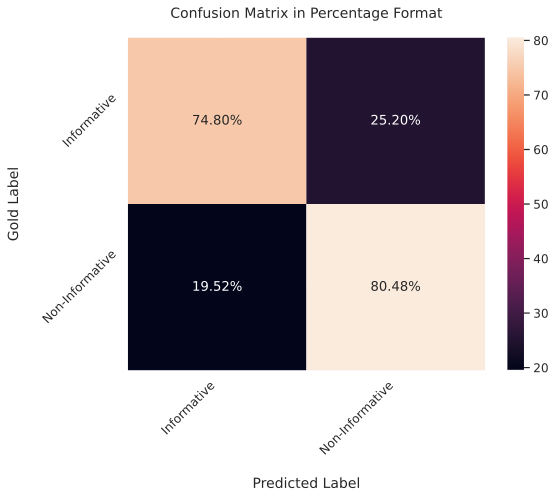

In [ ]:
model_lr = LogisticRegression(class_weight='balanced', max_iter=1000)
model_lr.fit(train_embeddings, train_targets)

#Calculating predictions, and accuracy score
pred_lr = model_lr.predict(test_embeddings)
accuracy = accuracy_score(test_targets, pred_lr)

#Building classification report
print("Classification Report for Logistic Regression with Sentence Embeddings")
print(f"F1 Score:{f1_score(test_targets, pred_lr, average='macro')}")
print(f"Accuracy : {accuracy}")
print(classification_report(test_targets,pred_lr))
plot_cm_with_percentages(test_targets, pred_lr, np.unique(train_informative_labels))

## Logistic Regression + Sentence Embeddings + All features

---



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Classification Report for Logistic Regression with Sentence Embeddings and All Handcrafted Features
              precision    recall  f1-score   support

           0       0.68      0.73      0.71       980
           1       0.85      0.82      0.84      1870

    accuracy                           0.79      2850
   macro avg       0.77      0.78      0.77      2850
weighted avg       0.80      0.79      0.79      2850

F1 Score:0.7728680265157695
Accuracy : 0.791578947368421


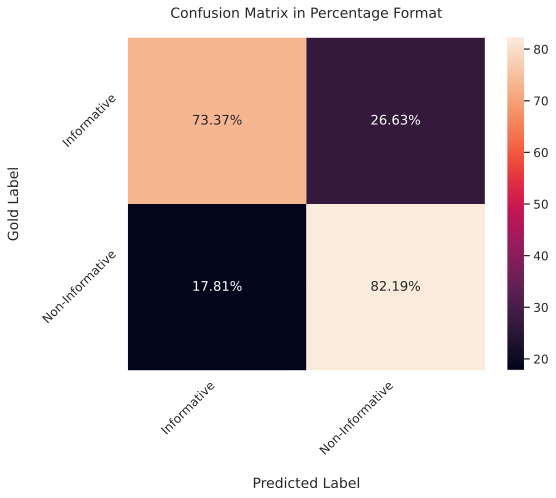

In [ ]:
features_train=np.concatenate([train_embeddings, train_context_embeddings, train_merged_df[model_features].values], axis=1)
features_test=np.concatenate([test_embeddings, test_context_embeddings, test_merged_df[model_features].values], axis=1)

model_lr = LogisticRegression(class_weight='balanced', max_iter=5000)
model_lr.fit(features_train, train_targets)

#Calculating predictions, and accuracy score
pred_lr = model_lr.predict(features_test)
accuracy = accuracy_score(test_targets, pred_lr)

#Building classification report
print("Classification Report for Logistic Regression with Sentence Embeddings and All Handcrafted Features")
print(classification_report(test_targets,pred_lr))
print(f"F1 Score:{f1_score(test_targets, pred_lr, average='macro')}")
print(f"Accuracy : {accuracy}")
plot_cm_with_percentages(test_targets, pred_lr, np.unique(train_informative_labels))

## Logistic Regression + Sentence Embeddings + Best selected features

In [ ]:
best_features_to_include

['election_distance_abs',
 'hour_sin',
 'hour_cos',
 'is_action1',
 'is_action2',
 'is_action3',
 'is_action4',
 'is_action5',
 'sentiment_cpd',
 'sentiment_neg',
 'sentiment_neu',
 'sentiment_pos']

In [ ]:
temporal_features = ['election_distance_abs', 'hour_sin', 'hour_cos']

In [ ]:
test_features = ['election_distance_abs',
 'hour_sin',
 'hour_cos',
 'sentiment_cpd',
 'sentiment_neg',
 'sentiment_neu',
 'sentiment_pos']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Classification Report for Logistic Regression with Sentence Embeddings
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       980
           1       0.86      0.82      0.84      1870

    accuracy                           0.79      2850
   macro avg       0.77      0.78      0.77      2850
weighted avg       0.80      0.79      0.79      2850

F1 Score:0.7723257797270955
Accuracy : 0.791578947368421


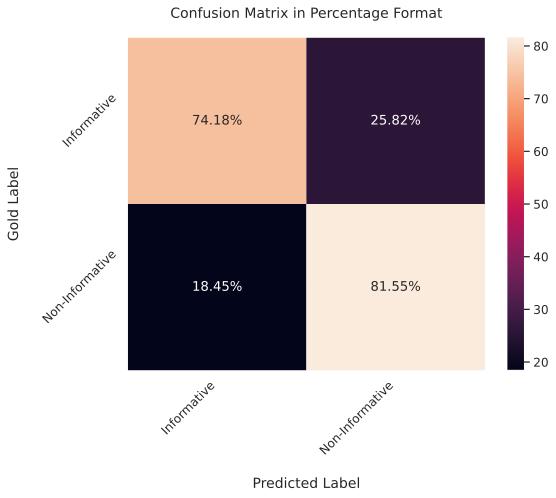

In [ ]:
features_train=np.concatenate([train_embeddings, train_context_embeddings, train_merged_df[test_features].values], axis=1)
features_test=np.concatenate([test_embeddings, test_context_embeddings, test_merged_df[test_features].values], axis=1)
features_val=np.concatenate([val_embeddings, val_context_embeddings, val_merged_df[test_features].values], axis=1)

model_lr = LogisticRegression(class_weight='balanced', max_iter=5000)
model_lr.fit(features_train, train_targets)

#Calculating predictions, and accuracy score
pred_lr = model_lr.predict(features_test)
accuracy_score(test_targets, pred_lr)

#Building classification report
print("Classification Report for Logistic Regression with Sentence Embeddings")
print(classification_report(test_targets,pred_lr))
print(f"F1 Score:{f1_score(test_targets, pred_lr, average='macro')}")
print(f"Accuracy : {accuracy}")
plot_cm_with_percentages(test_targets, pred_lr, np.unique(train_informative_labels))

## Experiments on the informative types classification task

In [ ]:
# Ablation Study for multilabel classification
# Process flow - train all features for the task of mulitlabel classification
# Test performance between LR and SVC - try SVC with OVR
# Carry out ablation study
# Document the results
# Move to bert based models - fusion of best features - temporal information, context, tweet features + Multitask learning - tomorrow(see how it performs)

In [ ]:
train_informative_df = train_merged_df[train_merged_df['informative_label'] == 'Informative']
val_informative_df = val_merged_df[val_merged_df['informative_label'] == 'Informative']
test_informative_df = test_merged_df[test_merged_df['informative_label'] == 'Informative']

In [ ]:
train_informative_df.shape

(3414, 30)

In [ ]:
print(train_informative_df.shape, val_informative_df.shape, test_informative_df.shape)

(3414, 30) (483, 30) (980, 30)


In [ ]:
# Probably reset train_data index
train_df = train_data.reset_index(drop=True)

In [ ]:
test_df = test_data.reset_index(drop=True)

In [ ]:
val_df = val_data.reset_index(drop=True)

In [ ]:
train_mask = train_df[train_df['informative_label'] == 'Informative'].index.values

In [ ]:
test_mask = test_df[test_df['informative_label'] == 'Informative'].index.values

In [ ]:
val_mask = val_df[val_df['informative_label'] == 'Informative'].index.values

In [ ]:
train_informative_embeddings = train_embeddings[train_mask]
train_informative_context_embeddings = train_context_embeddings[train_mask]
train_informative_df = train_df[train_df['informative_label'] == 'Informative']
print(train_informative_embeddings.shape, train_informative_context_embeddings.shape,
      train_informative_df.shape)

(3414, 768) (3414, 768) (3414, 16)


In [ ]:
test_informative_embeddings = test_embeddings[test_mask]
test_informative_context_embeddings = test_context_embeddings[test_mask]
test_informative_df = test_df[test_df['informative_label'] == 'Informative']
print(test_informative_embeddings.shape, test_informative_context_embeddings.shape,
      test_informative_df.shape)

(980, 768) (980, 768) (980, 16)


In [ ]:
val_informative_embeddings = val_embeddings[val_mask]
val_informative_context_embeddings = val_context_embeddings[val_mask]
val_informative_df = val_df[val_df['informative_label'] == 'Informative']
print(val_informative_embeddings.shape, val_informative_context_embeddings.shape,
      val_informative_df.shape)

(483, 768) (483, 768) (483, 16)


In [ ]:
features_informative_train = np.concatenate([train_informative_embeddings, train_informative_context_embeddings, train_informative_df[model_features].values], axis=1)
features_informative_test = np.concatenate([test_informative_embeddings, test_informative_context_embeddings, test_informative_df[model_features].values], axis=1)
features_informative_val = np.concatenate([val_informative_embeddings, val_informative_context_embeddings, val_informative_df[model_features].values], axis=1)

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(train_informative_df['label'])
train_informative_targets = le.transform(train_informative_df['label'])
test_informative_targets = le.transform(test_informative_df['label'])
val_informative_targets = le.transform(val_informative_df['label'])
mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(mapping)

{'Counting and Results': 0, 'Political Rallies': 1, 'Positive Events': 2, 'Security Issues': 3, 'Voting Issues': 4}


In [ ]:
# Perform cross validation
scores = cross_val_score(LogisticRegression(class_weight='balanced', max_iter=5000), features_informative_train, train_informative_targets, cv=5, scoring='f1_macro')
# Calculate average F1 score
average_score = scores.mean()
print(f"Logistic Regression with all features for classifying informative types:{average_score}")

Accuracy on hold-out set 0.6894409937888198 

                      precision    recall  f1-score   support

Counting and Results       0.69      0.77      0.73       101
   Political Rallies       0.51      0.68      0.58        38
     Positive Events       0.78      0.72      0.75       170
     Security Issues       0.66      0.69      0.67        61
       Voting Issues       0.66      0.57      0.61       113

            accuracy                           0.69       483
           macro avg       0.66      0.69      0.67       483
        weighted avg       0.70      0.69      0.69       483



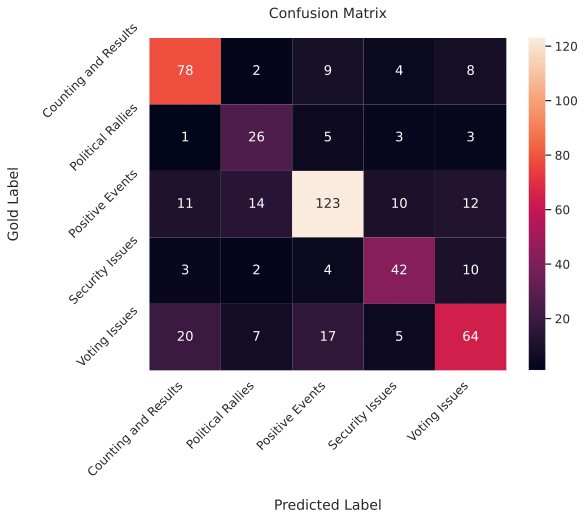

In [ ]:
model_lr = LogisticRegression(class_weight='balanced', max_iter=3000)
model_lr.fit( features_informative_train, train_informative_targets)
evaluate_model(features_informative_val, val_informative_targets, model_lr, mapping.keys())

In [ ]:
predicted = model_lr.predict(features_informative_val)
original_report = classification_report(val_informative_targets,predicted, output_dict=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy on hold-out set 0.6832298136645962 

                      precision    recall  f1-score   support

Counting and Results       0.69      0.70      0.70       101
   Political Rallies       0.63      0.71      0.67        38
     Positive Events       0.75      0.71      0.73       170
     Security Issues       0.62      0.72      0.67        61
       Voting Issues       0.64      0.60      0.62       113

            accuracy                           0.68       483
           macro avg       0.67      0.69      0.68       483
        weighted avg       0.69      0.68      0.68       483



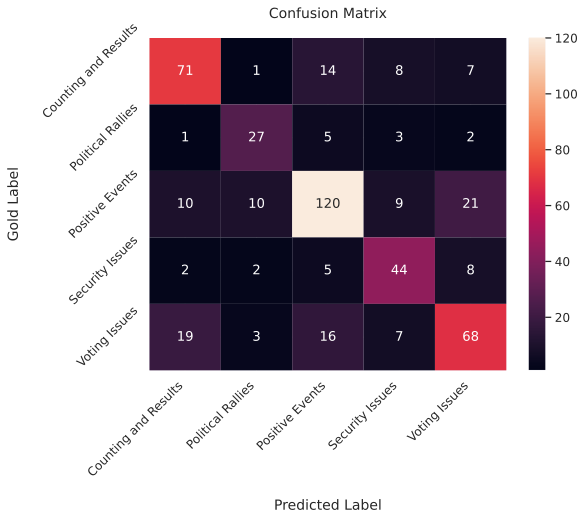

In [ ]:
# Just using the embeddings only
model_lr = LogisticRegression(class_weight='balanced', max_iter=3000)
model_lr.fit(train_informative_embeddings, train_informative_targets)
evaluate_model(val_informative_embeddings, val_informative_targets, model_lr, mapping.keys())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy on hold-out set 0.6811594202898551 

                      precision    recall  f1-score   support

Counting and Results       0.66      0.66      0.66       101
   Political Rallies       0.52      0.63      0.57        38
     Positive Events       0.74      0.79      0.76       170
     Security Issues       0.66      0.67      0.67        61
       Voting Issues       0.68      0.56      0.61       113

            accuracy                           0.68       483
           macro avg       0.65      0.66      0.66       483
        weighted avg       0.68      0.68      0.68       483



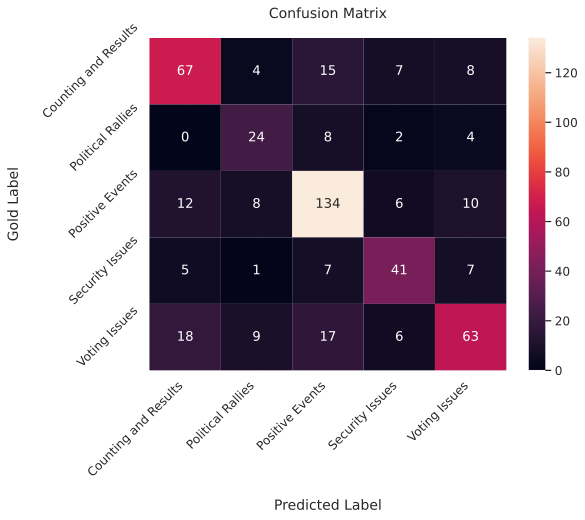

In [ ]:
model_lsvc = LinearSVC(class_weight='balanced', max_iter=3000)
model_lsvc.fit(features_informative_train, train_informative_targets)
evaluate_model(features_informative_val, val_informative_targets, model_lsvc, mapping.keys())

In [ ]:
# Carry out ablation study using Logistic Regression - simple and faster to train

In [ ]:
from sklearn.model_selection import cross_val_predict

In [ ]:
feature_performance = {}

In [ ]:
for grouped_feature in grouped_features.keys():
  if grouped_features[grouped_feature] == True:
      # Train without any context
      print("Training without any context embeddings...")
      features_train=np.concatenate([train_informative_embeddings, train_informative_df[model_features].values], axis=1)
      features_val=np.concatenate([val_informative_embeddings, val_informative_df[model_features].values], axis=1)
  else:
      print(f"Training without the following features {grouped_features[grouped_feature]}")
      features_to_include = list(set(model_features) - set(grouped_features[grouped_feature]))
      features_train = np.concatenate([train_informative_embeddings, train_informative_context_embeddings,
                                     train_informative_df[features_to_include].values], axis=1)
      features_val = np.concatenate([val_informative_embeddings, val_informative_context_embeddings,
                                     val_informative_df[features_to_include].values], axis=1)


  classifier = LogisticRegression(class_weight='balanced', max_iter=5000)
  classifier.fit(features_train, train_informative_targets)
  predicted = classifier.predict(features_val)
  # Generate classification report
  report = classification_report(val_informative_targets, predicted, output_dict=True)
  feature_performance[grouped_feature] = report
  print(f"Feature: {grouped_feature}")
  print(f"Modified Performance: {report}")
  print("")


In [ ]:
ablation_df = pd.DataFrame.from_dict(feature_performance)

In [ ]:
ablation_df.head()

In [ ]:
# ablation_df = pd.read_csv('ablation_study.csv', encoding='utf-8', index_col=0)

In [ ]:
# Group by class then draw graph for each class

In [ ]:
ablation_df

In [ ]:
test = ablation_df.head(1)

In [ ]:
test

In [ ]:
labels = [0,1,2,3,4]

In [ ]:
ablation_df.iloc[0]

In [ ]:
mapping = {'Counting and Results': 0, 'Political Rallies': 1, 'Positive Events': 2, 'Security Issues': 3, 'Voting Issues': 4}

In [ ]:
# Switch the keys and values
switched_dict = {value: key for key, value in mapping.items()}

print(switched_dict)

In [ ]:
classes_performance = []
for label in labels:
  label_dict = {}
  print(f"Processing scores for label {label}")
  record = ablation_df.iloc[label]
  feature_dict = {}
  for key in grouped_features.keys():
    clf_report = record[key]
    f1_score = clf_report['f1-score']
    all_features_f1 = original_report[f'{label}']['f1-score']
    feature_dict[key] = all_features_f1-f1_score
  label_dict[switched_dict[label]] = feature_dict
  classes_performance.append(label_dict)

In [ ]:
classes_performance

In [ ]:
# Extract the classes and changes from the data
classes = []
changes = []
for item in classes_performance:
    class_name = list(item.keys())[0]
    change = item[class_name]
    classes.append(class_name)
    changes.append(change)

In [ ]:
feature_names

In [ ]:
formatted_feature_names = [s.replace('_', ' ').title() for s in feature_names]
print(formatted_feature_names)

In [ ]:
# Get the feature names
feature_names = list(changes[0].keys())
# Create a bar plot for all classes sharing the same x-axis
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(classes):
  values = list(changes[i].values())
  plt.bar(formatted_feature_names, values, label=class_name)

plt.title('Changes in Classes')
plt.xlabel('Features')
plt.ylabel('Change')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Comparison between LR with Sentence Embeddings and LR with sentence embeddings + handcrafted features

## Logistic Regression with Sentence Embeddings

Accuracy on hold-out set 0.7163265306122449 

                      precision    recall  f1-score   support

Counting and Results       0.73      0.74      0.73       206
   Political Rallies       0.66      0.77      0.71        78
     Positive Events       0.79      0.67      0.73       345
     Security Issues       0.67      0.79      0.72       122
       Voting Issues       0.67      0.71      0.69       229

            accuracy                           0.72       980
           macro avg       0.70      0.74      0.72       980
        weighted avg       0.72      0.72      0.72       980



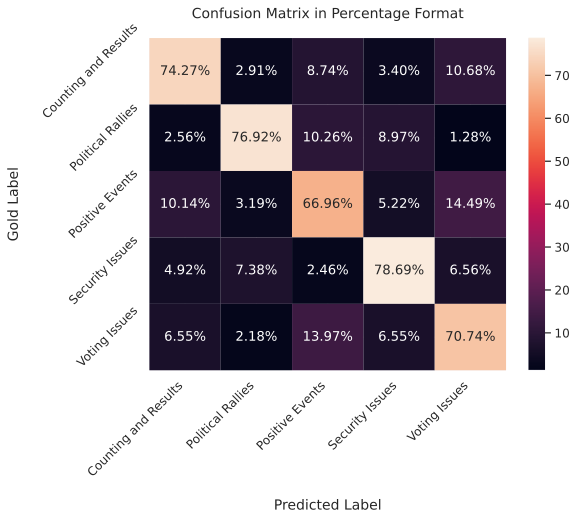

In [ ]:
model_lr = LogisticRegression(class_weight='balanced', max_iter=5000)
model_lr.fit(train_informative_embeddings, train_informative_targets)
evaluate_model(test_informative_embeddings, test_informative_targets, model_lr, mapping.keys(),True)

In [ ]:
# Build classifier with best features
best_features = ['temporal_features', 'sentiment_features']
features_to_include = []
for f in best_features:
  features_to_include = features_to_include + grouped_features[f]

In [ ]:
features_to_include

['election_distance_abs',
 'hour_sin',
 'hour_cos',
 'sentiment_cpd',
 'sentiment_neg',
 'sentiment_neu',
 'sentiment_pos']

Accuracy on hold-out set 0.7438775510204082 

                      precision    recall  f1-score   support

Counting and Results       0.74      0.81      0.77       206
   Political Rallies       0.74      0.86      0.80        78
     Positive Events       0.83      0.71      0.77       345
     Security Issues       0.68      0.77      0.72       122
       Voting Issues       0.67      0.68      0.68       229

            accuracy                           0.74       980
           macro avg       0.73      0.77      0.75       980
        weighted avg       0.75      0.74      0.74       980



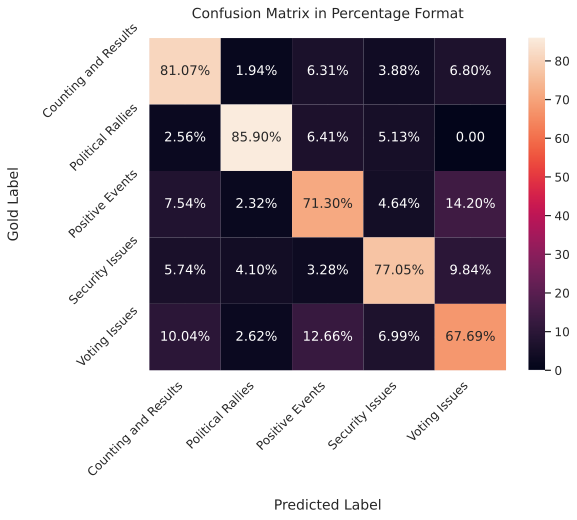

In [ ]:
features_informative_train = np.concatenate([train_informative_embeddings, train_informative_context_embeddings, train_informative_df[features_to_include].values], axis=1)
features_informative_test = np.concatenate([test_informative_embeddings, test_informative_context_embeddings, test_informative_df[features_to_include].values], axis=1)

model_lr = LogisticRegression(class_weight='balanced', max_iter=5000)
model_lr.fit( features_informative_train, train_informative_targets)
evaluate_model(features_informative_test, test_informative_targets, model_lr, mapping.keys())